In [308]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import time
import tqdm

from matplotlib import cm
from matplotlib.colors import Normalize


# Define functions

In [333]:
def time_of_contacts(contacts, ser_l, start=None, end=None, type_of_contact=None, empty=False):
    """
    Extracts the times of contact events for specific serines indices.

    Args:
        contacts (np.ndarray): Array of contact events where each row represents [time, series_index, contact_type,...].
        ser_l (list or int): List of serines indices to consider or single serine index.
        start (int, optional): The start time for consideration.
        end (int, optional): The end time to consider for contact events.
        type_of_contact (int, optional): Filter contacts by type. Default is None (no filtering), if +1 only accepted phosphorylations, if -1 accepted dephosphorylation, if 0 rejected phosphorylations, if +2 rejected dephosphorylations.
        empty (bool): If True, return `end` time for serines with no contacts. Default is False.

    Returns:
        list: A list of arrays, each containing the contact times for a specific serine index.
    """
    # Sanity check
    if start is not None and end is not None and start > end:
        raise ValueError('Start time cannot be greater than end time!')
    if empty and end is None:
        raise ValueError('end time must be specified when empty is True!')
        
    # Filter contacts by type if specified
    tmp = contacts if type_of_contact is None else contacts[contacts[:, 2] == type_of_contact]
    # Filter contacts by start and end time if specified
    if start is not None:
        tmp = tmp[tmp[:, 0] > start]
    if end is not None:
        tmp = tmp[tmp[:, 0] < end]
    
    # Initialize the list to hold contact times for each serine index
    times = []
    if isinstance(ser_l, int) or isinstance(ser_l, np.int32) or isinstance(ser_l, np.int64):
        list_sers = [ser_l]
    else:
        list_sers = ser_l
    # Iterate over each serine index
    for i in list_sers:
        # Extract contact times for the current serine index
        contact_times = tmp[tmp[:, 1] == i, 0]
        
        # If empty=True and no contact times found, assign the `end` time
        if empty and len(contact_times) == 0:
            contact_times = np.array([end])
        
        times.append(contact_times)
    
    return times

In [203]:
def estimator_rate_single_exponential(dirpath, file_suffix, ser_l, n_sims, max_time, start_time=None):
    """
    Estimates the rate of a single-exponential process from contact times.
    
    Args:
        dirpath (str): Directory path containing simulation files.
        file_suffix (str): Common suffix of the filenames to be loaded. It contains the name of the contacts-file follwing the prefix 'sim{index}_'.
        ser_l (np.ndarray): List of serines indices to consider.
        n_sims (int): Number of simulations to analyze.
        max_time (int): Maximum time to consider for contact events.
        start_time (int, optional): The start time for consideration in contact events.

    Returns:
        tuple: Estimated rates and associated uncertainties (d_r) for each serine.
    """

    # Initialize the array to store contact times
    times = np.empty((24, 0))

    # Process each simulation
    for i in range(n_sims):
        # Load the simulation data
        c_tmp = np.loadtxt(f"{dirpath}/sim{i+1}_{file_suffix}", ndmin=2)
        
        if c_tmp.size > 0:
            # Filter contacts by start_time and max_time
            c_tmp = c_tmp[c_tmp[:, 0] < max_time]
            if start_time is not None:
                c_tmp = c_tmp[c_tmp[:, 0] > start_time]
                c_tmp[:,0] -= start_time     # if start_time not 0, we need to translate time
                max_time -= start_time
                
            # Get contact times
            t_tmp = time_of_contacts(c_tmp, ser_l=ser_l, end=max_time, type_of_contact=1, empty=True)
            times = np.append(times, t_tmp, axis=1)

    # Calculate rates and their uncertainties
    n_contacts = [len(times[i][times[i] != max_time]) + 1 for i in range(24)]
    total_time = times.sum(axis=1)
    rates = np.array(n_contacts) / total_time
    d_r = np.sqrt(n_contacts) / total_time
    
    return rates, d_r

In [204]:
def count_contacts(dirpath, file_suffix, ser_l, n_sims, type_of_contact=None, len_prot=154, n_prot=1, start=None, end=None):
    """
    Counts the number of contacts (or specific kinds of contacts) in simulations.

    Args:
        dirpath (str): Directory path containing simulation files.
        file_suffix (str): Common suffix of the filenames to be loaded.
        ser_l (np.ndarray): List of serine indices to consider.
        n_sims (int): Number of simulations to analyze.
        type_of_contact (int, optional): Specific type of contact to filter by. Defaults to None (no filtering), if +1 only accepted phosphorylations, if -1 accepted dephosphorylation, if 0 rejected phosphorylations, if +2 rejected dephosphorylations.
        len_prot (int, optional): Length of the protein sequence. Defaults to 154 (TDP-43 LCD length).
        n_prot (int, optional): Number of protein chains to consider. Defaults to 1.
        start (int, optional): Start time to filter contacts. Defaults to None (start from the beginning).
        end (int, optional): End time to filter contacts. Defaults to None (consider contacts up to the end of the simulation).

    Returns:
        tuple: The average count of contacts across simulations and the standard error of the counts.
    """

    counts = []
    if isinstance(n_sims, int):
        sims_list = [s for s in range(n_sims)]
    elif isinstance(n_sims, list):
        sims_list = n_sims
    else:
        raise ValueError('n_sims must be int or list of int!')
    for s in sims_list:
        tmp = np.loadtxt(dirpath+f"/sim{s+1}_{file_suffix}", ndmin=2)
        
        # Filter contacts by type if specified
        if type_of_contact is not None:
            tmp = tmp[tmp[:, 2] == type_of_contact]

        # Filter contacts by start and end time if specified
        if start is not None:
            tmp = tmp[tmp[:, 0] > start]
        if end is not None:
            tmp = tmp[tmp[:, 0] < end]
        
        # Calculate the number of contacts for each serial in ser_l across proteins
        sim_counts = [
            sum(len(np.where(tmp[:, 1] == i + len_prot * j )[0]) for j in range(n_prot))
            for i in ser_l
        ]
        
        counts.append(sim_counts)
        
    # Calculate the average count and the standard error across simulations
    count_average = np.mean(counts, axis=0)
    count_err = np.std(counts, axis=0)/np.sqrt(len(sims_list)-1)

    return count_average, count_err

In [356]:
def pcc_compute(xdata, ydata):
    """
    Computes the Pearson correlation coefficient (PCC) between two datasets.
    
    Args:
        xdata (np.ndarray): 1D array of values for the x variable.
        ydata (np.ndarray): 1D array of values for the y variable.

    Returns:
        float: The Pearson correlation coefficient between xdata and ydata.
    """
    mux = np.mean(xdata)
    muy = np.mean(ydata)
    covxy = np.sum((xdata-mux)*(ydata-muy))
    varx = np.sum((xdata-mux)**2)
    vary = np.sum((ydata-muy)**2)
    
    return covxy/np.sqrt(varx*vary)

def linear(t, r1,c):
    return c + r1*t

In [291]:
def plot_correlation(ratex, ratey, dratex, dratey, ser_l, sing_ser=None, title=None, xlabel=None, ylabel=None, save=None):

    popt, pcov = curve_fit(linear, ratex, ratey)
    corr = pcc_compute(ratex, ratey)
    
    plt.figure(figsize=(4.3,3.5))

    norm = Normalize(vmin=np.min(ser_l), vmax=np.max(ser_l))
    tt = np.linspace(np.min(ratex), np.max(ratex),10)

    plt.plot(tt, linear(tt,*popt), '--k',linewidth=0.5)
    plt.errorbar(ratex, ratey, dratey, dratex, '.', capsize=4, linewidth=0.5, alpha=0.6)
    plt.scatter(ratex, ratey, marker='o', c=norm(ser_l), cmap='viridis', edgecolor='k', s=60, alpha=1, linewidth=0.5)

    if sing_ser is not None:
        print(ser_l[sing_ser])
        plt.scatter([ratex[sing_ser]], [ratey[sing_ser]], marker='o', c='w', edgecolor='k', s=100, alpha=1, linewidth=0.5)
        if isinstance(sing_ser, list):
            for serid in sing_ser:
                plt.text(ratex[serid], ratey[serid], f'{ser_l[serid]}')
        else:
            plt.text(ratex[sing_ser], ratey[sing_ser], f'{ser_l[sing_ser]}')

    color_bar = plt.colorbar(cm.ScalarMappable(norm=norm))
    color_bar.set_label('Ser number')
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.text(np.min(ratex), np.max(ratey), f'correlation = {corr:.2f}')

    if title is not None:
        plt.title(title, fontsize=9)
    
    if save is not None:
        plt.savefig(save)
        
    plt.show()

Fit functions

In [357]:
def linear(t, r1,c):
    return c + r1*t

def inv_double_exp(t, a1,a2 ):
    """
    Computes the inverse cumulative probability of having an event within time t, 
    where the underlying process is exponential (rate a1) conditioned to another exponential process (a2).
    
    Args:
        t (float or np.ndarray): Time or independent variable.
        a1 (float): The first rate constant.
        a2 (float): The second rate constant.

    Returns:
        float or np.ndarray: inverse cumulative probability.
    """
    k1 = np.abs(a1)
    k2 = np.abs(a2)
    
    return k1*k2*( np.exp(-k2*t)/k2 - np.exp(-k1*t)/k1 )/(k1-k2)

def inv_double_same_rate(t, r1):
    """
    Computes the inverse cumulative probability of having an event within time t, 
    where the underlying process is exponential conditioned to another exponential process and the two processes have same rate r1.
    
    Args:
        t (float or np.ndarray): Time or independent variable.
        r1 (float): Rate constant.
        
    Returns:
        float or np.ndarray: inverse cumulative probability.
    """
    return (1 + r1*t) * np.exp(-r1*t)

In [358]:
def histogram_phosphorylation_times(dirpath, file_suffix, ser_idx, n_sims, max_time, start_time=None):
    """
    Generates a histogram of phosphorylation times for a specific serine index across multiple simulations.
    
    Args:
        dirpath (str): Directory containing the simulation files.
        file_suffix (str): Suffix of the simulation files to load.
        ser_idx (int or np.ndarray): Index or indices of serines to consider for phosphorylation.
        n_sims (int): Number of simulations to analyze.
        max_time (float): Maximum time to consider for phosphorylation events.
        start_time (float, optional): Start time to consider for phosphorylation events (default is None).
    
    Returns:
        tuple: 
            - counts (np.ndarray): Normalized histogram counts of phosphorylation times.
            - bins (np.ndarray): The bin edges of the histogram in microseconds (µs).
    """
    times = []
    for s in range(n_sims):
        contacts = np.loadtxt(dirpath+f"/sim{s+1}_{file_suffix}", ndmin=2)
        # Get the phosphorylation times for the specified serine indices
        time_tmp = time_of_contacts(contacts, ser_idx, start=start_time, end=max_time, type_of_contact=1, empty=True)
        times.extend(time_tmp)
    
    counts, bins = np.histogram(times, bins=200)
    bins = bins/100000000     # units in µs
    counts = counts/n_sims    # normalize by number of simulations
    bins[0] = 0      # Set the first bin edge to 0 µs
    
    return counts, bins


In [359]:
def plot_exponential_fits(counts, bins, ser_idx=None, same_rate=False, title=None, save=None):
    """
    Plot exponential fits of phosphorylation data using single and double exponential models.
    
    Args:
        counts (np.ndarray): Histogram counts of phosphorylation times.
        bins (np.ndarray): Bin edges corresponding to phosphorylation times in µs.
        ser_idx (int, optional): Serine index for labeling (default is None).
        same_rate (bool, optional): If True, use a model with the same rate for both exponential components. Default is False.
        title (str, optional): Title for the plot (default is None).
        save (str, optional): File path to save the figure (default is None).
        
    Returns:
        None
    """
    # Compute the inverse cumulative distribution (1 - cumulative sum of counts)
    inv_cumul = 1 - np.cumsum(counts)

    # Fit the inverse cumulative data to a linear (single-exponential) model
    popt_l, pcov_l = curve_fit(linear, bins[:-20], np.log(inv_cumul[:-19]))
    rp_se = -popt_l[0]
    err_se = np.sqrt(pcov_l.diagonal())[0]

    # Fit the data to a double-exponential model
    if same_rate:
        popt_s, pcov_s = curve_fit(inv_double_same_rate, bins[:-1], inv_cumul_first, p0=(0.025))
        r_s = popt_s[0]
        err_s = np.sqrt(pcov_s.diagonal())[0]
    else:
        popt, pcov = curve_fit(inv_double_exp, bins[:-1], inv_cumul, p0=(0.01, 0.0021))
        rp_de = popt[1]
        err_de = np.sqrt(pcov.diagonal())[1]
        rb_de = popt[0]
        errb_de = np.sqrt(pcov.diagonal())[0]

    plt.figure(figsize=(4,2.6))
    tt = np.linspace(0,bins[-1])
    plt.yscale('log')

    plt.xlim(0,bins[-1])
    plt.ylim(inv_cumul[-2]-0.001,1.05)
    plt.xlabel(r'T $\mathrm{[\mu s]}$')
    plt.ylabel('probability')

    plt.stairs(inv_cumul,bins, color='k', label=r'$1-P_c(t<T)$')

    if same_rate:
        plt.plot(tt, inv_double_same_rate(tt,*popt_s) , 'g', label='cond. same-rate')
    else:
        plt.plot(tt, inv_double_exp(tt,*popt) , color='r', label='conditioned')

    plt.plot(tt, np.exp(linear(tt, *popt_l)), '--b', label='single-exp')

    plt.legend()
    if ser_idx is not None:
        plt.text(bins[10],inv_cumul[100], f'S{ser_idx+260}', fontsize=12)
    plt.text(bins[10],inv_cumul[140], f'$r_P = {rp_se:.2f} \pm {err_se:.2f}$', fontsize=8, color='b')
    if same_rate:
        plt.text(bins[10],inv_cumul[170], f'$r_P = {r_s:.2f} \pm {err_s:.2f}$ ,  $r_B = {r_s:.2f} \pm {err_s:.2f}$', fontsize=8, color='g')
    else:
        plt.text(bins[10],inv_cumul[170], f'$r_P = {rp_de:.2f} \pm {err_de:.2f}$ ,  $r_B = {rb_de:.1f} \pm {errb_de:.1f}$', fontsize=8, color='r')
    
    if save is not None:
        plt.savefig(save, dpi=600)
    
    plt.show()

# Compute rates

Define Ser residues IDs

In [205]:
ser_i = np.array([266, 273, 292, 305, 317, 332, 333, 342, 347, 350, 369, 373, 375, 377, 379, 387, 389, 393, 395, 403, 404, 407, 409, 410])-260 
ser_i_full = ser_i+121 
ser_i_equi = np.linspace(8, 146, 24, dtype=int)
n_ser = len(ser_i)

Define path to data

### Rates single TDP-43 simulations

Phosphorylation rates

In [207]:
rates, drates = estimator_rate_single_exponential(dirpath='', file_suffix='short_ck1d-rigid-rescaled_tdp43_b30_32b_contacts.txt',
                                                  ser_l=ser_i, n_sims=100, max_time=2*10**8)
rates *= 10**8      # units \mu s^-1
drates *= 10**8

rates_h, drates_h = estimator_rate_single_exponential(dirpath='', file_suffix='short_ck1d-rigid-rescaled_homotdp43_b30_32b_contacts.txt',
                                                  ser_l=ser_i, n_sims=100, max_time=4*10**8)
rates_h *= 10**8      # units \mu s^-1
drates_h *= 10**8

rates_hequi, drates_hequi = estimator_rate_single_exponential(dirpath='', file_suffix='short_ck1d-rigid-rescaled_homotdp43-equiSER_b30_32b_contacts.txt',
                                                  ser_l=ser_i_equi, n_sims=100, max_time=4*10**8)
rates_hequi *= 10**8      # units \mu s^-1
drates_hequi *= 10**8

rates_f, drates_f = estimator_rate_single_exponential(dirpath='', file_suffix='short_full-ck1d-rigid-rescaled_tdp43_b30_32b_contacts.txt',
                                                  ser_l=ser_i_full, n_sims=100, max_time=4*10**8)
rates_f *= 10**8      # units \mu s^-1
drates_f *= 10**8


Contact rates in equilibrium  simulations

In [208]:
rc, drc = count_contacts(dirpath='', file_suffix='np_b30_32b_ck1d-rigid-rescaled_tdp43_contacts.txt',
                                                  ser_l=ser_i, n_sims=30)
rc /= 15.    # counts of contacts divided by time, production run is 15 \mu s
drc /= 15.

rc_h, drc_h = count_contacts(dirpath='', file_suffix='np_b30_32b_ck1d-rigid-rescaled_homotdp43_contacts.txt',
                                                  ser_l=ser_i, n_sims=30)

rc_hequi, drc_hequi = count_contacts(dirpath='', file_suffix='np_b30_32b_ck1d-rigid-rescaled_homotdp43-equiSER_contacts.txt',
                                                  ser_l=ser_i_equi, n_sims=30)

rc_f, drc_f = count_contacts(dirpath='', file_suffix='np_b30_32b_full-ck1d-rigid-rescaled_tdp43_contacts.txt',
                                                  ser_l=ser_i_full, n_sims=30)

rc_h /= 30.
drc_h /= 30.
rc_hequi /= 30.
drc_hequi /= 30.
rc_f /= 30.
drc_f /= 30.

### Rates condensate simulations

Phosphorylation rates folded CK1d

In [261]:
rp_1c_fold, drp_1c_fold = count_contacts(dirpath='', file_suffix='1-folded-ck1d_multi-tdp43_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, type_of_contact=1, len_prot=154, n_prot=200, end=5*10**8)
rp_1c_fold /= 5.  # \mu s
drp_1c_fold/= 5.  # \mu s

rp_3c_fold, drp_3c_fold = count_contacts(dirpath='', file_suffix='3-folded-ck1d_multi-tdp43_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, type_of_contact=1, len_prot=154, n_prot=200, end=2*10**8)
rp_3c_fold /= 3  # kinases
drp_3c_fold/= 3  # kinases
rp_3c_fold /= 2  # \mu s
drp_3c_fold/= 2  # \mu s

rp_5c_fold, drp_5c_fold = count_contacts(dirpath='', file_suffix='5-folded-ck1d_multi-tdp43_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, type_of_contact=1, len_prot=154, n_prot=200, end=10**8)

rp_5c_fold /= 5  # kinases
drp_5c_fold/= 5  # kinases
rp_5c_fold /= 1.  # \mu s
drp_5c_fold/= 1.  # \mu s


Phosphorylation rates full-length CK1d

In [247]:
rp_1c_full, drp_1c_full = count_contacts(dirpath='', file_suffix='full-ck1d_multi-tdp43_hps-r03_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=10, type_of_contact=1, len_prot=154, n_prot=200)
rp_1c_full /= 3.  # \mu s
drp_1c_full/= 3.  # \mu s

rp_2c_full, drp_2c_full = count_contacts(dirpath='', file_suffix='2-full-ck1d_multi-tdp43_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, type_of_contact=1, len_prot=154, n_prot=200)

rp_2c_full /= 2  # kinases
drp_2c_full/= 2  # kinases
rp_2c_full /= 5.  # \mu s
drp_2c_full/= 5.  # \mu s

rp_3c_full, drp_3c_full = count_contacts(dirpath='', file_suffix='3-full-ck1d_multi-tdp43_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, type_of_contact=1, len_prot=154, n_prot=200)
rp_3c_full /= 3  # kinases
drp_3c_full/= 3  # kinases
rp_3c_full /= 5.  # \mu s
drp_3c_full/= 5.  # \mu s


Contact rates in equilibrium  simulations folded CK1d

In [229]:
rc_1c_fold, drc_1c_fold = count_contacts(dirpath='', file_suffix='1-folded-ck1d_multi-tdp43_np_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, len_prot=154, n_prot=200)
rc_1c_fold /= 5.  # \mu s
drc_1c_fold/= 5.  # \mu s

rc_3c_fold, drc_3c_fold = count_contacts(dirpath='', file_suffix='3-folded-ck1d_multi-tdp43_np_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, len_prot=154, n_prot=200)
rc_3c_fold /= 3  # kinases
drc_3c_fold/= 3  # kinases
rc_3c_fold /= 5.  # \mu s
drc_3c_fold/= 5.  # \mu s

rc_5c_fold, drc_5c_fold = count_contacts(dirpath='', file_suffix='5-folded-ck1d_multi-tdp43_np_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, len_prot=154, n_prot=200)

rc_5c_fold /= 5  # kinases
drc_5c_fold/= 5  # kinases
rc_5c_fold /= 5.  # \mu s
drc_5c_fold/= 5.  # \mu s

Contact rates in equilibrium  simulations full-length CK1d

In [274]:
rc_1c_full, drc_1c_full = count_contacts(dirpath='', file_suffix='full-ck1d_multi-tdp43_np_hps-r03_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=10, len_prot=154, n_prot=200, end=10**8)
rc_1c_full /= 1.  # \mu s
drc_1c_full/= 1.  # \mu s

rc_2c_full, drc_2c_full = count_contacts(dirpath='', file_suffix='2-full-ck1d_multi-tdp43_np_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, len_prot=154, n_prot=200)

rc_2c_full /= 2  # kinases
drc_2c_full/= 2  # kinases
rc_2c_full /= 5.  # \mu s
drc_2c_full/= 5.  # \mu s

rc_3c_full, drc_3c_full = count_contacts(dirpath='', file_suffix='3-full-ck1d_multi-tdp43_np_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, len_prot=154, n_prot=200)
rc_3c_full /= 3  # kinases
drc_3c_full/= 3  # kinases
rc_3c_full /= 5.  # \mu s
drc_3c_full/= 5.  # \mu s


### Plots

In [248]:
plt.style.use('default')
plt.style.use('rates_plot.mplstyle')

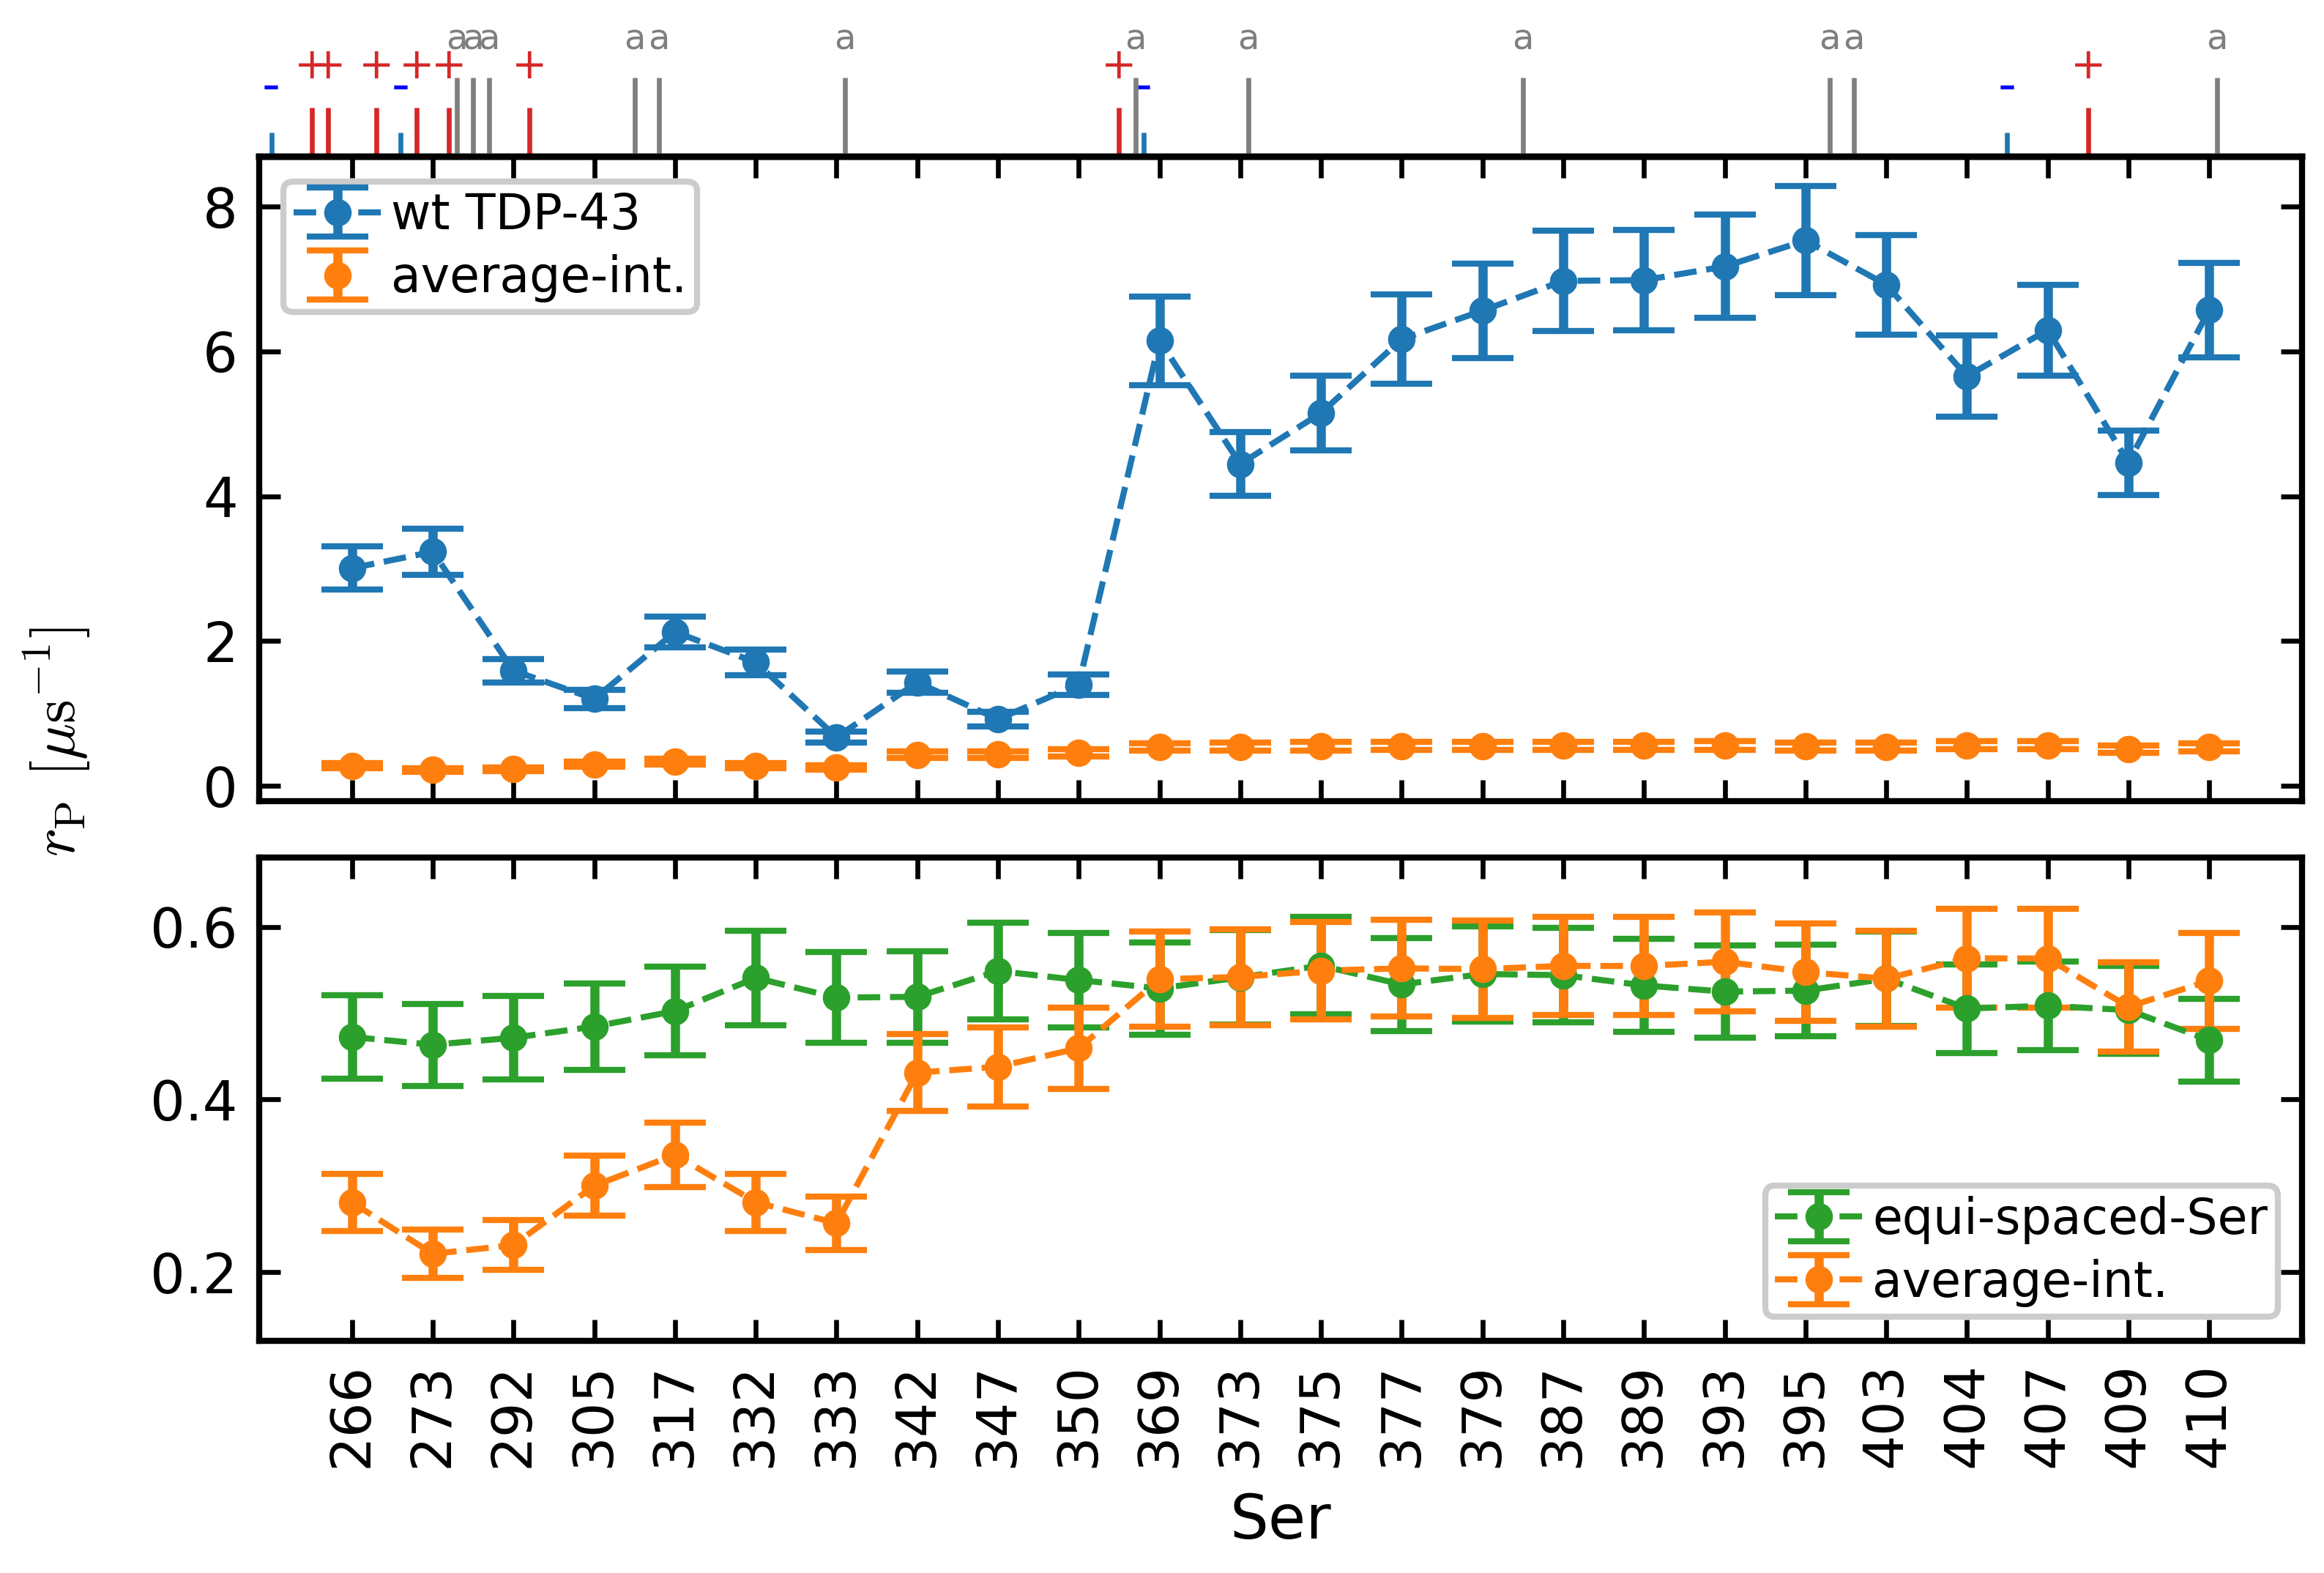

In [214]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,3.5), sharex=True, gridspec_kw={'height_ratios': [2, 1.5]})
plt.subplots_adjust(hspace=0.1)

ax1.errorbar(np.arange(1,25), rates, drates, fmt='.--', color='tab:blue', elinewidth=1.5, capsize=5, markersize=7,  label=r'wt TDP-43')
ax1.errorbar(np.arange(1,25), rates_h, drates_h, fmt='.', color='tab:orange', elinewidth=1.5, capsize=5, markersize=7,  label=r'average-int.')

ax2.errorbar(np.arange(1,25), rates_hequi, drates_hequi, fmt='.--', color='tab:green', elinewidth=1.5, capsize=5, markersize=7,  label=r'equi-spaced-Ser')
ax2.errorbar(np.arange(1,25), rates_h, drates_h, fmt='.--', color='tab:orange', elinewidth=1.5, capsize=5, markersize=7,  label=r'average-int.')

# zoom-in / limit the view to different portions of the data
ax2.set_ylim(.12, .68)  # outliers only

ax2.set_xticks(np.arange(1,25) , ser_i+260, rotation="vertical" )
ax1.tick_params( direction='in', top=True, right=True)  # don't put tick labels at the top
ax2.tick_params(direction='in', top=True, right=True)  # don't put tick labels at the top

ax1.legend(loc='upper left', framealpha=1)
ax2.legend(framealpha=1)
ax2.set_xlabel('Ser')

secax = ax1.secondary_xaxis('top')
secax.set_xticks([0.5, 0.7, 1.3, 1.8, 2.2, 3.2, 10.5, 22.5], ['+']*8, color='tab:red', fontsize='x-small' )
secax.tick_params(direction='out', color='tab:red' , length=8)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([0., 1.6, 10.8, 21.5], ['-']*4, color='blue', fontsize='small' )
secax2.tick_params(direction='out', color='tab:blue' , length=4)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([2.3,2.5,2.7,4.5, 4.8,7.1, 10.7, 12.1, 15.5, 19.3, 19.6, 24.1], ['a']*12, color='tab:grey', fontsize='xx-small' )
secax2.tick_params(direction='out', color='tab:grey' , length=13)
f.text(0.035, 0.5, '$r_\mathrm{P}$ $\mathrm{[\mu s^{-1}]}$', va='center', rotation='vertical')

plt.show()

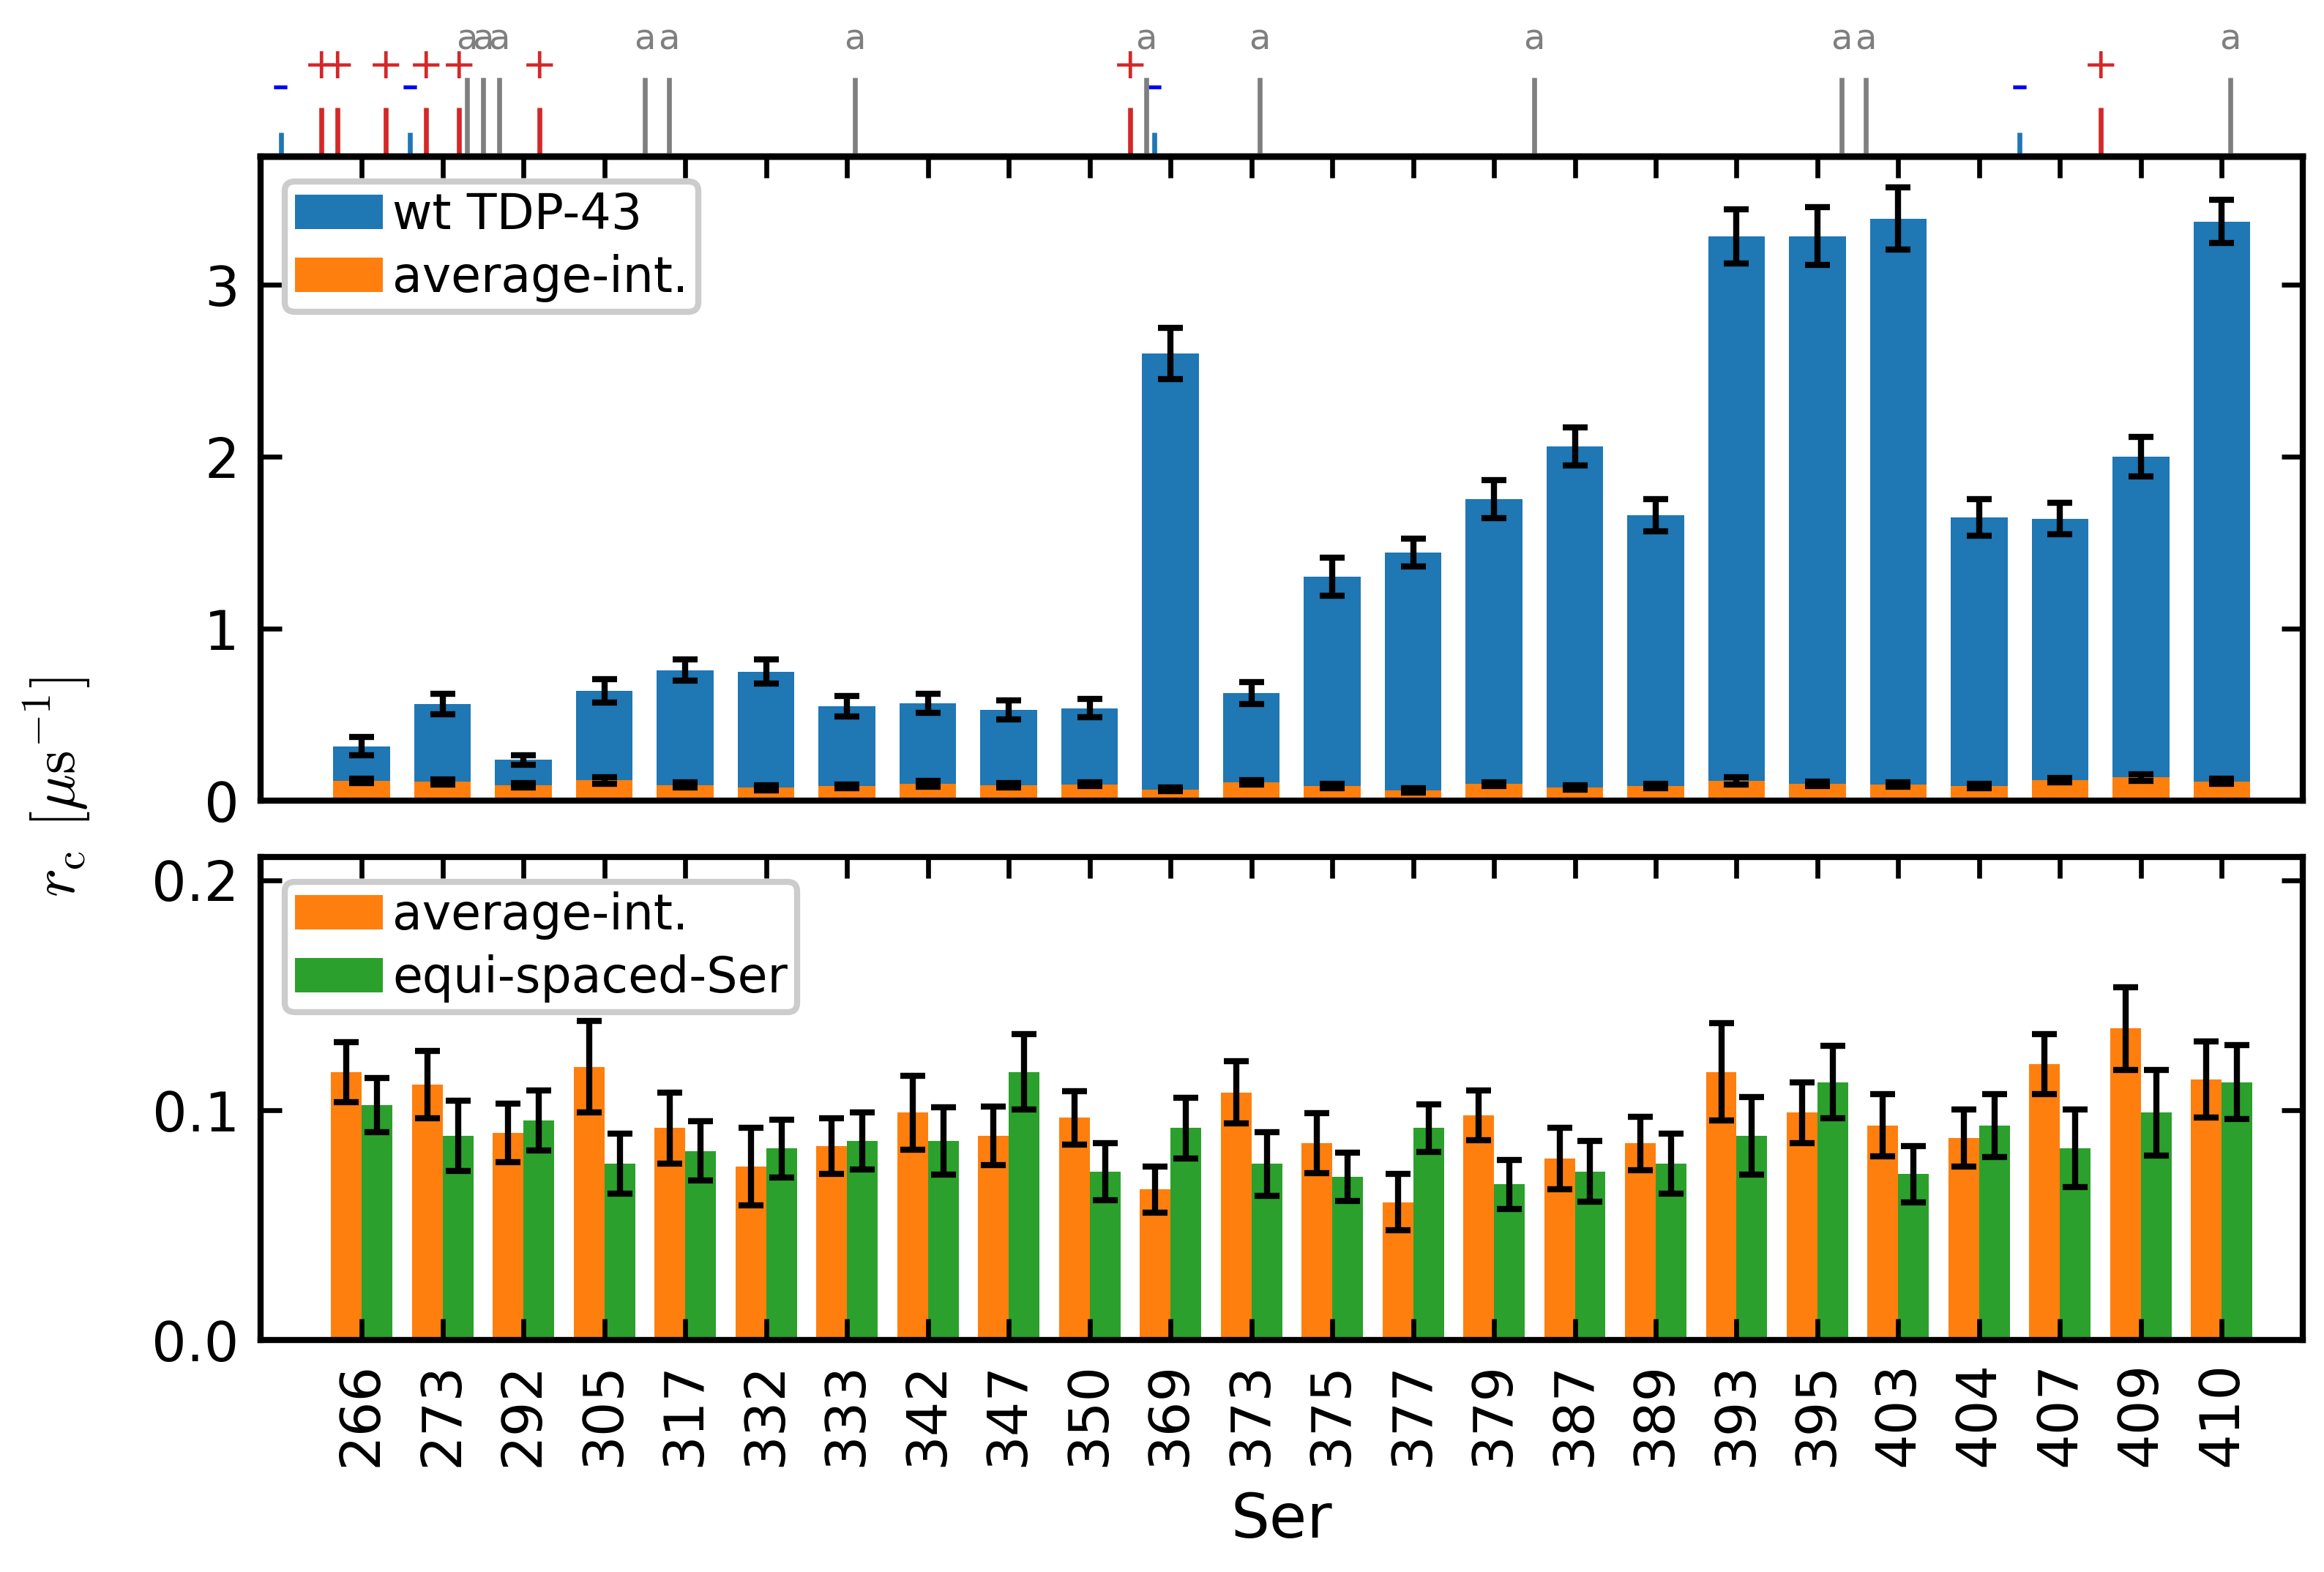

In [234]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,3.5), sharex=True, gridspec_kw={'height_ratios': [2, 1.5]})
shift=0.38

plt.text(-3.2,0.2,r"$r_\mathrm{c}$ $\mathrm{[\mu s^{-1}]}$ ", rotation='vertical')
plt.xlim(-0.25,25)
plt.subplots_adjust(hspace=0.1)

# plot the same data on both axes
ax1.bar(np.arange(1,25), rc, color='tab:blue', yerr=drc, width=0.7, capsize=2, label=r"wt TDP-43")
ax1.bar(np.arange(1,25), rc_h, yerr=drc_h,  width=0.7, color='tab:orange', capsize=2, label='average-int.')
ax2.bar(np.arange(1,25)-shift/2, rc_h, yerr=drc_h,  width=shift, color='tab:orange', capsize=2, label='average-int.')
ax2.bar(np.arange(1,25)+shift/2, rc_hequi, yerr=drc_hequi,  width=shift, color='tab:green', capsize=2, label='equi-spaced-Ser')

# zoom-in / limit the view to different portions of the data
ax2.set_ylim(.0, .21)  # outliers only
ax2.set_xticks(np.arange(1,25) , ser_i+260 , rotation="vertical" )
ax2.set_xlabel("Ser")

ax2.set_xticks(np.arange(1,25) , ser_i+260, rotation="vertical" )
ax1.tick_params( direction='in', bottom=False, top=True, right=True)  # don't put tick labels at the top
ax2.tick_params(direction='in', top=True, right=True)  # don't put tick labels at the top

ax1.legend(loc='upper left', framealpha=1)
ax2.legend(loc='upper left', framealpha=1)

secax = ax1.secondary_xaxis('top')
secax.set_xticks([0.5, 0.7, 1.3, 1.8, 2.2, 3.2, 10.5, 22.5], ['+']*8, color='tab:red', fontsize='x-small' )
secax.tick_params(direction='out', color='tab:red' , length=8)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([0., 1.6, 10.8, 21.5], ['-']*4, color='blue', fontsize='small' )
secax2.tick_params(direction='out', color='tab:blue' , length=4)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([2.3,2.5,2.7,4.5, 4.8,7.1, 10.7, 12.1, 15.5, 19.3, 19.6, 24.1], ['a']*12, color='tab:grey', fontsize='xx-small' )
secax2.tick_params(direction='out', color='tab:grey' , length=13)

plt.show()

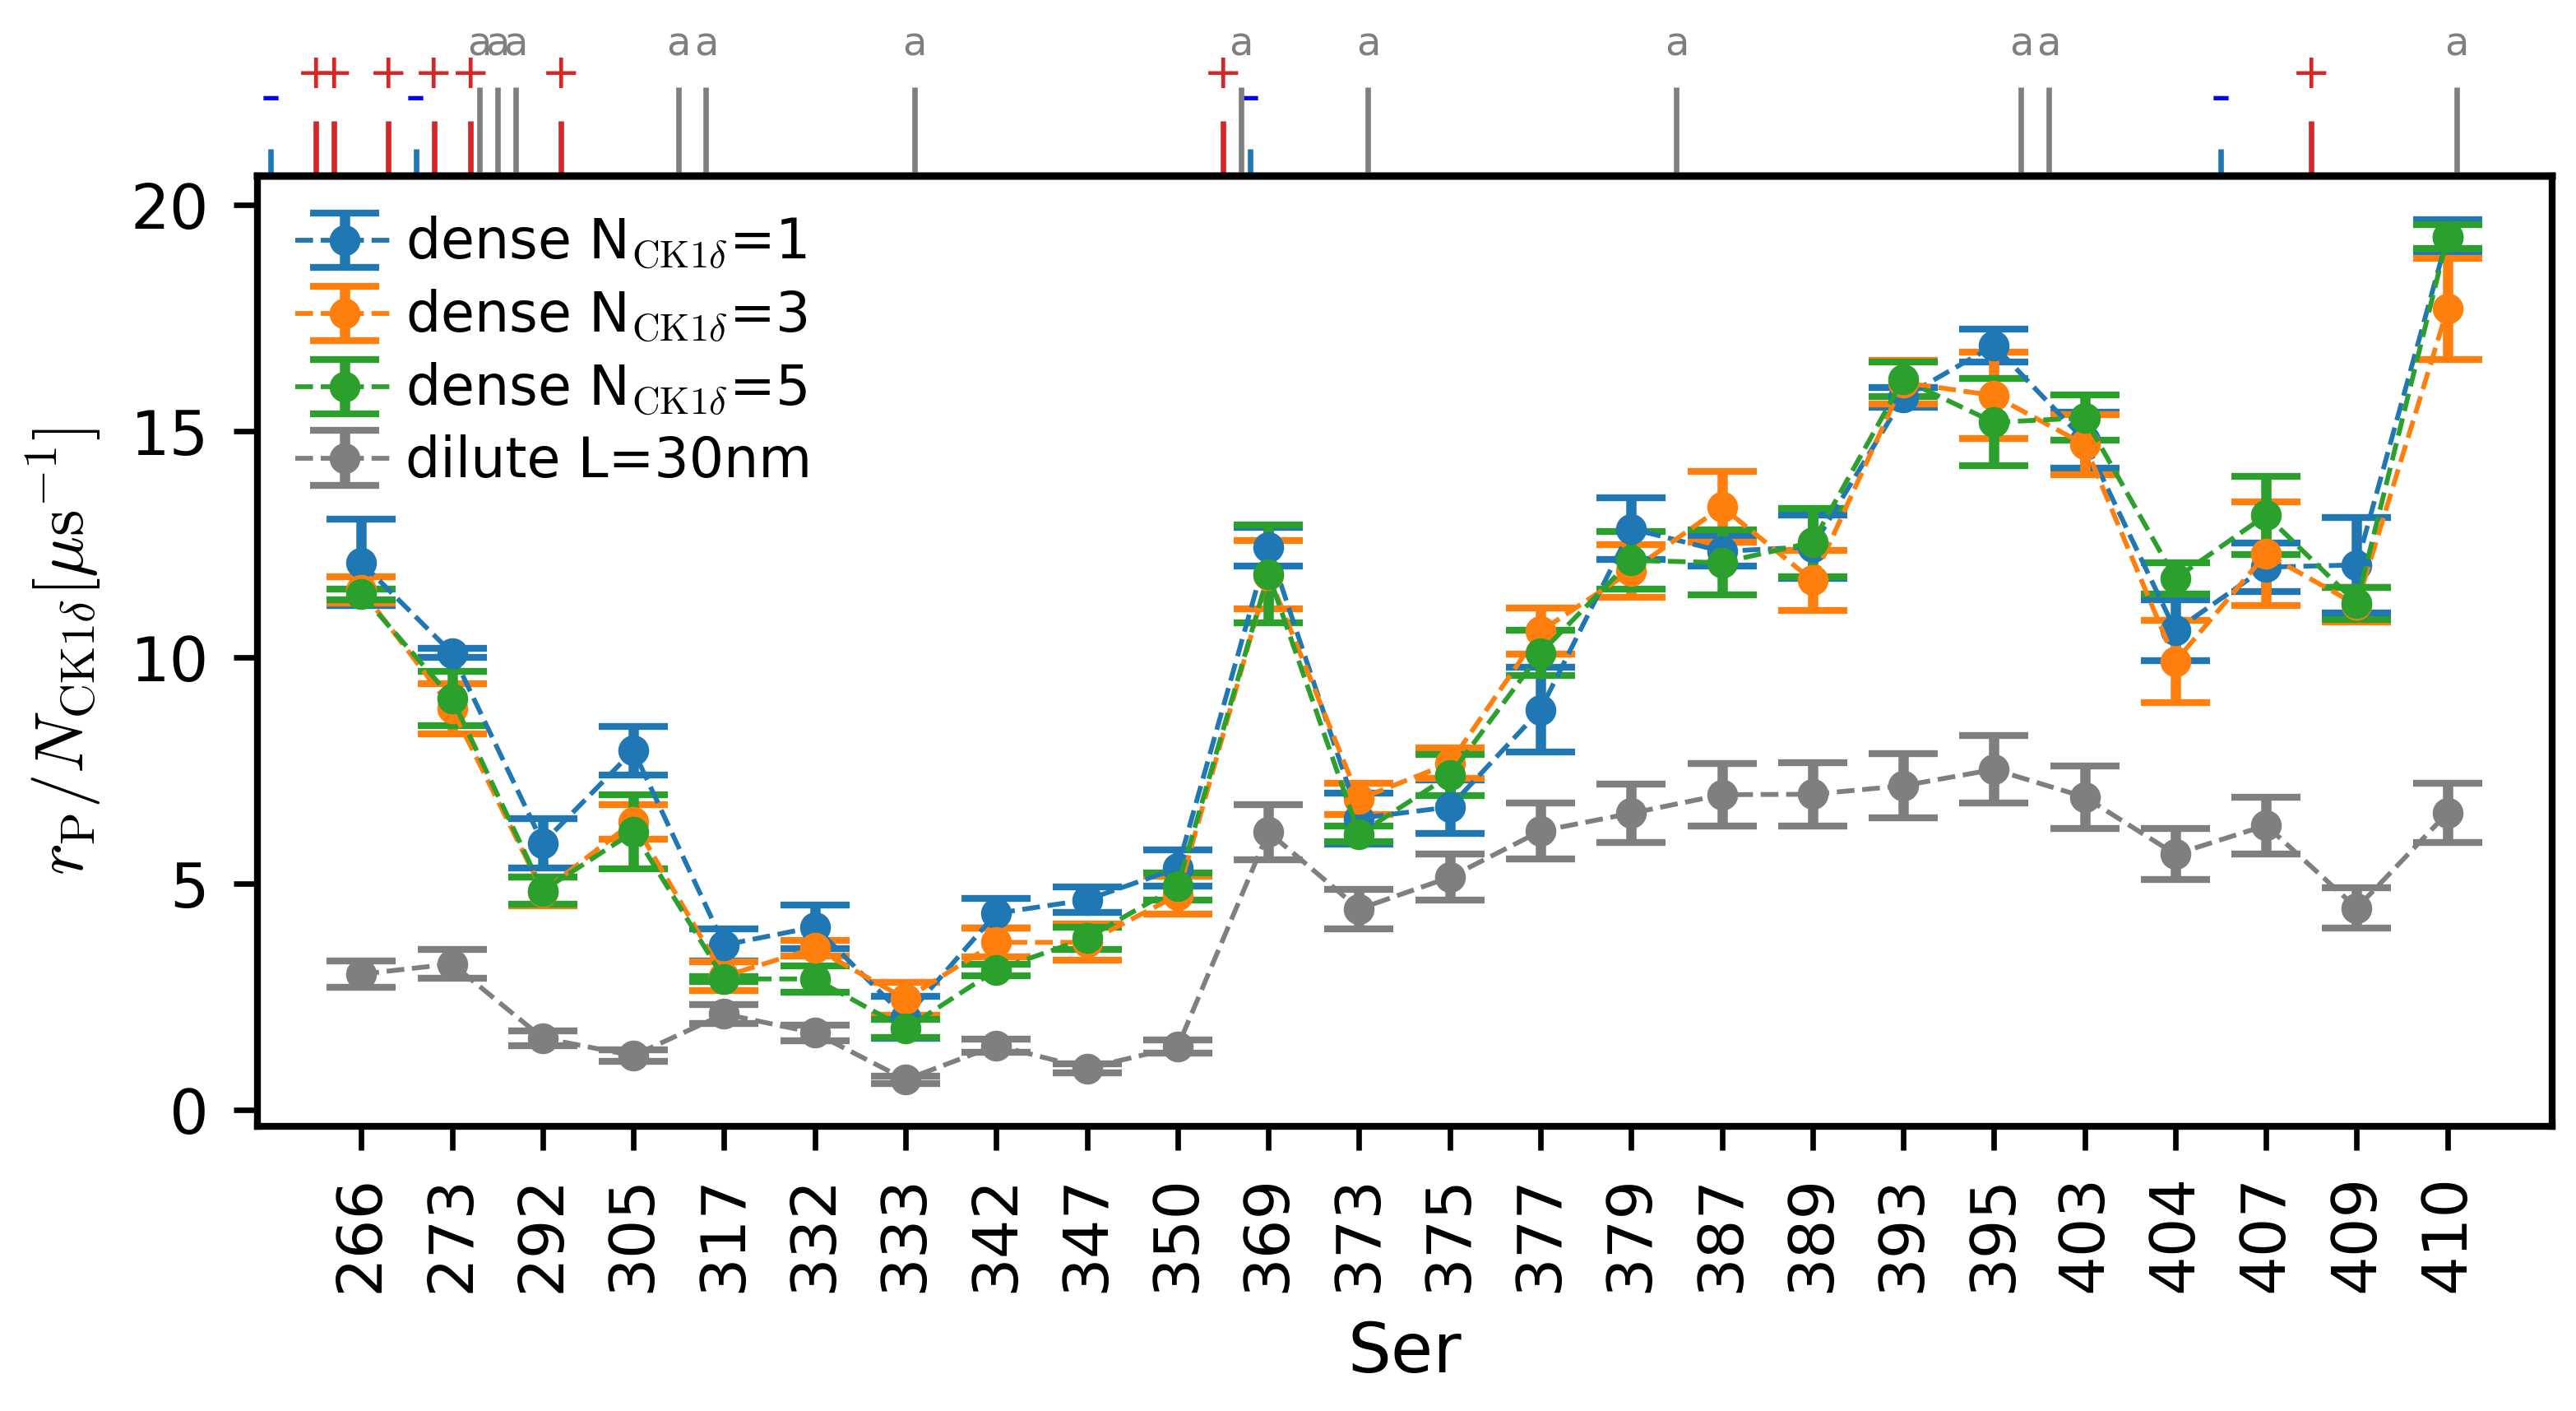

In [271]:
f, ax1 = plt.subplots(figsize=(6,2.5))

ax1.errorbar(np.arange(1,25), rp_1c_fold, drp_1c_fold, fmt='.--', color='tab:blue', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"dense N$_{\mathrm{CK1\delta}}$=1")
ax1.errorbar(np.arange(1,25), rp_3c_fold, drp_3c_fold, fmt='.--', color='tab:orange', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"dense N$_{\mathrm{CK1\delta}}$=3")
ax1.errorbar(np.arange(1,25), rp_5c_fold, drp_5c_fold, fmt='.--', color='tab:green', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"dense N$_{\mathrm{CK1\delta}}$=5")
ax1.errorbar(np.arange(1,25), rates, drates, fmt='.--', color='tab:grey', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r'dilute L=30nm')

secax = ax1.secondary_xaxis('top')
secax.set_xticks([0.5, 0.7, 1.3, 1.8, 2.2, 3.2, 10.5, 22.5], ['+']*8, color='tab:red', fontsize='x-small' )
secax.tick_params(direction='out', color='tab:red' , length=8)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([0., 1.6, 10.8, 21.5], ['-']*4, color='blue', fontsize='small' )
secax2.tick_params(direction='out', color='tab:blue' , length=4)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([2.3,2.5,2.7,4.5, 4.8,7.1, 10.7, 12.1, 15.5, 19.3, 19.6, 24.1], ['a']*12, color='tab:grey', fontsize='xx-small' )
secax2.tick_params(direction='out', color='tab:grey' , length=13)


plt.legend(loc='upper left', framealpha=1, ncols=1)
plt.xticks(np.arange(1,25) , ser_i+260, rotation="vertical" )
plt.xlabel('Ser')
plt.ylabel('$r_{\mathrm{P}}/N_{\mathrm{CK1\delta}} [\mathrm{\mu s}^{-1}]$')
plt.show()

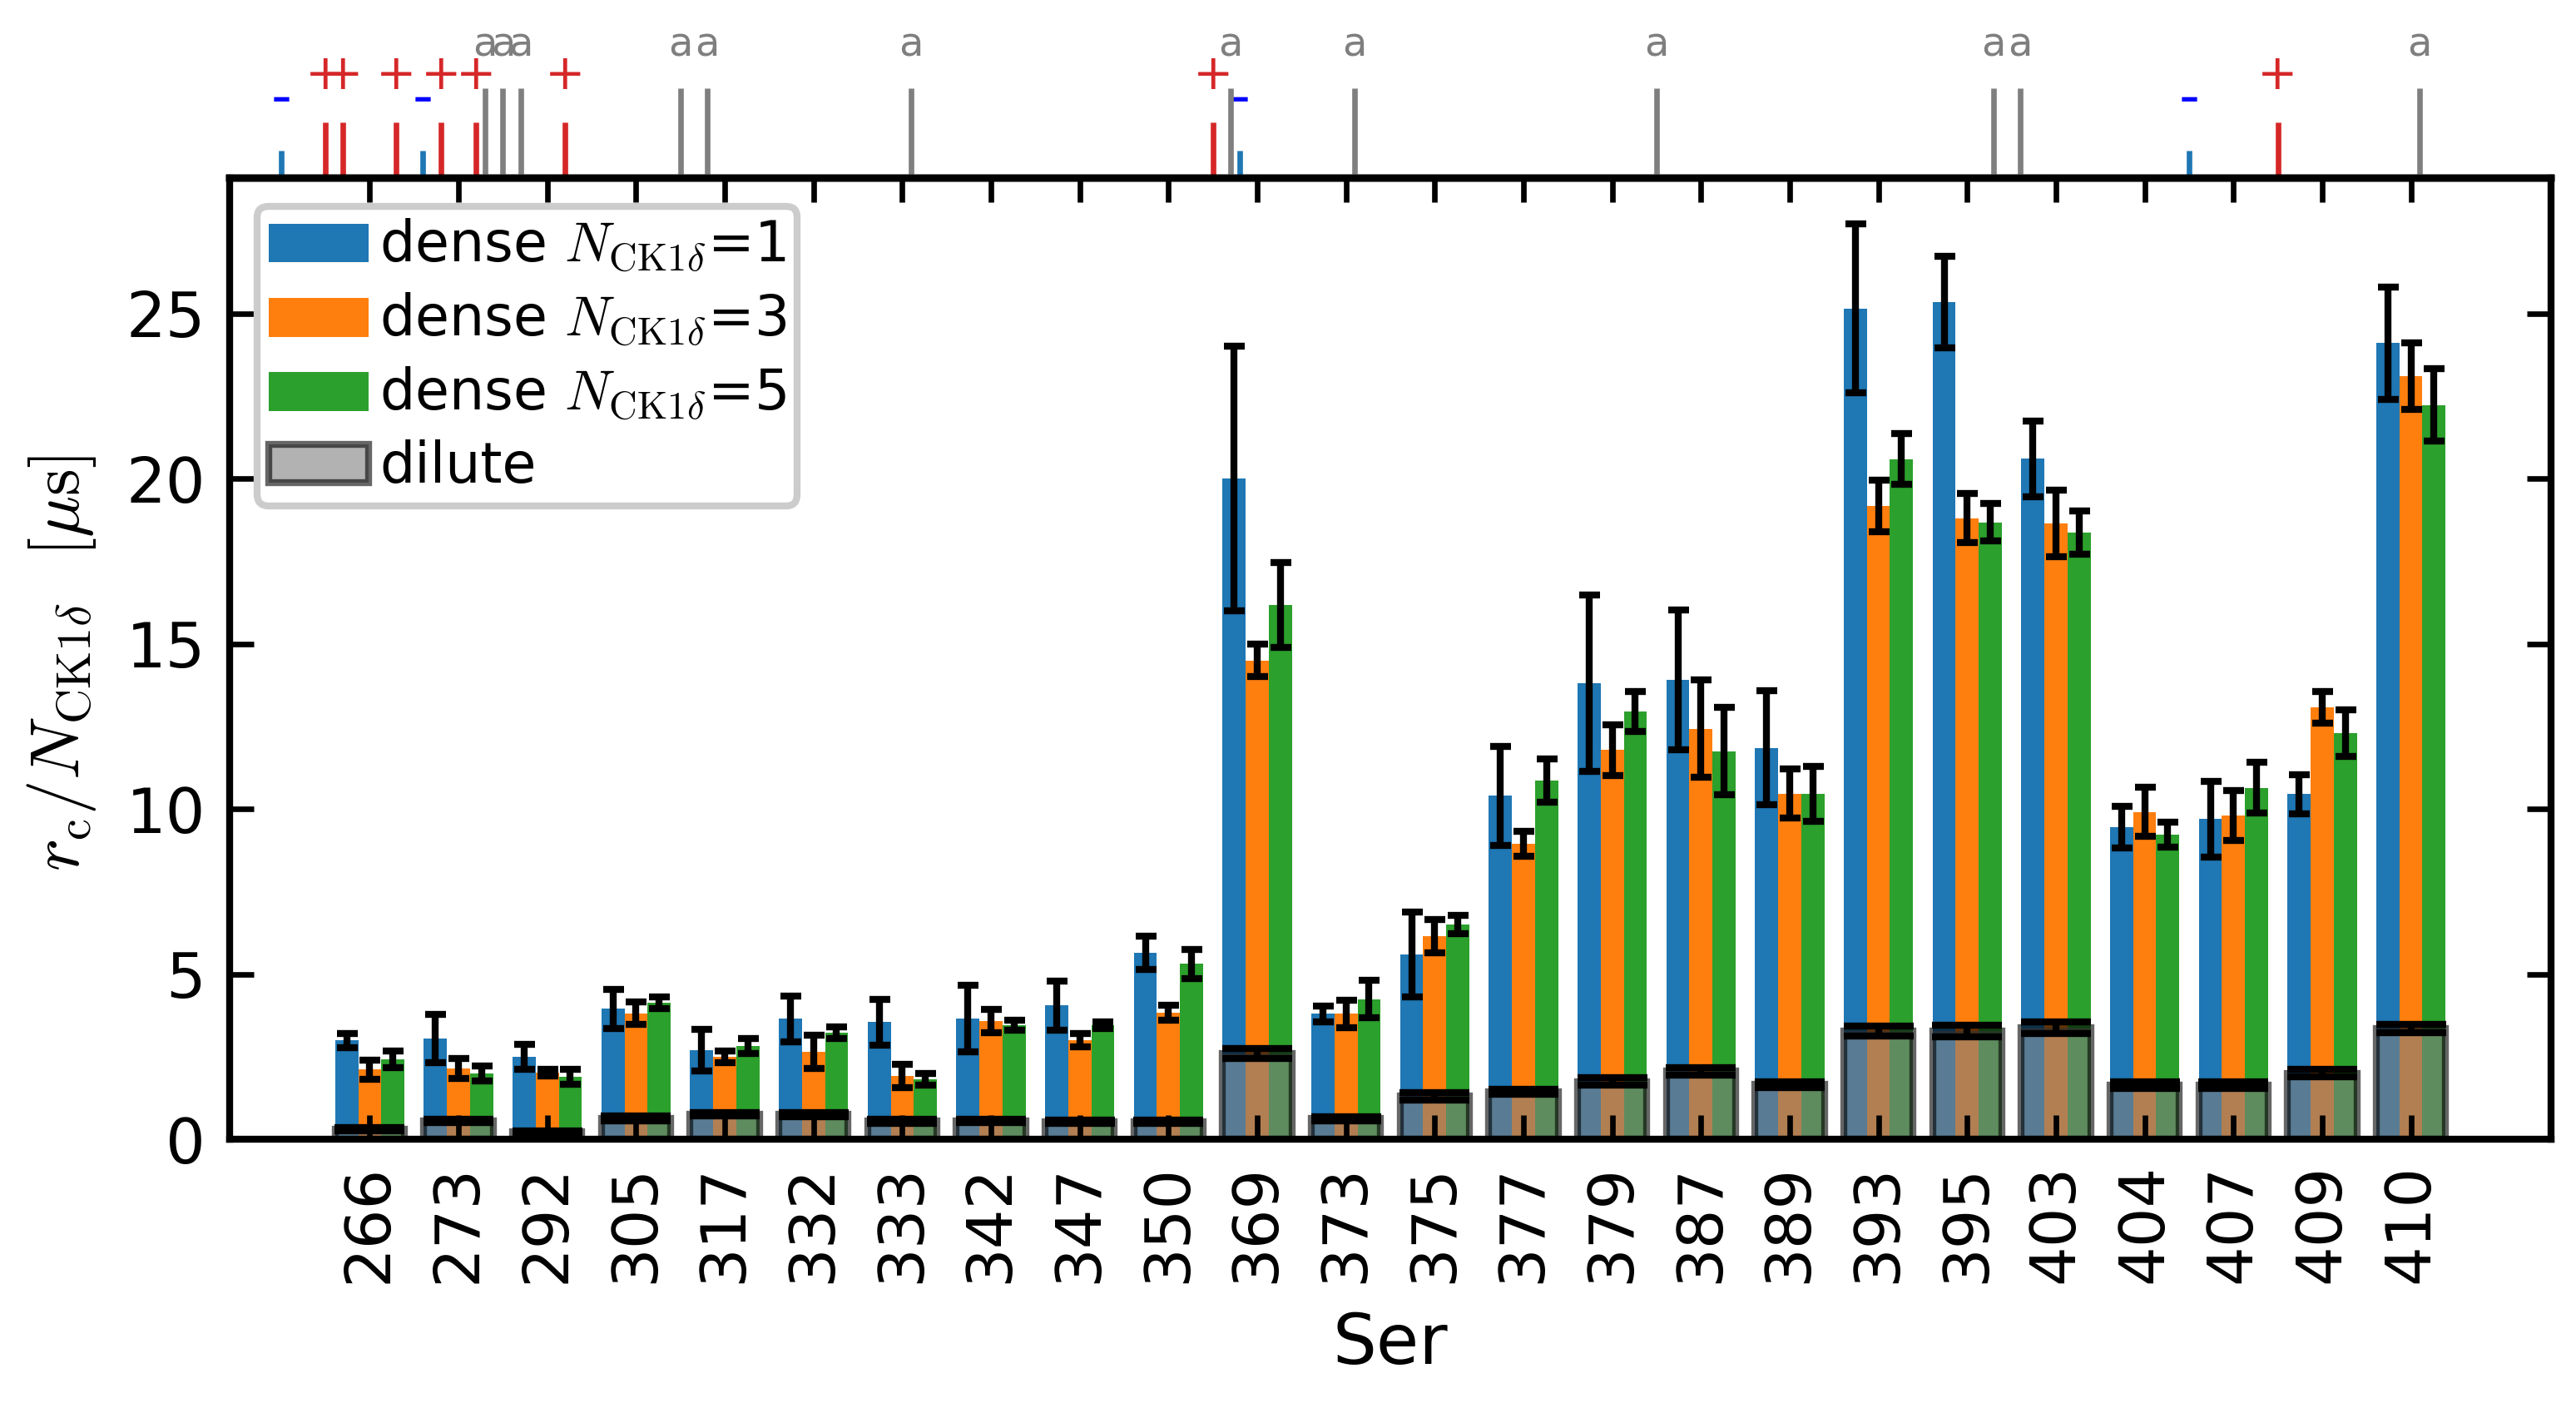

In [236]:
f,ax1 = plt.subplots(figsize=(6,2.5))
shift = 0.26

plt.bar(np.arange(1,25)-shift, rc_1c_fold, yerr=drc_1c_fold, width=shift, capsize=1.5, label=r"dense $N_{\mathrm{CK1\delta}}$=1")
plt.bar(np.arange(1,25), rc_3c_fold, yerr=drc_3c_fold, width=shift, capsize=1.5, label=r"dense $N_{\mathrm{CK1\delta}}$=3")
plt.bar(np.arange(1,25)+shift, rc_5c_fold, yerr=drc_5c_fold, width=shift, capsize=1.5, label=r"dense $N_{\mathrm{CK1\delta}}$=5")
plt.bar(np.arange(1,25), rc, yerr=drc, alpha=0.6, color='grey', edgecolor='k', width=shift*3, capsize=5, label=r"dilute")

plt.xticks(np.arange(1,25) , ser_i+260 , rotation="vertical" )

secax = ax1.secondary_xaxis('top')
secax.set_xticks([0.5, 0.7, 1.3, 1.8, 2.2, 3.2, 10.5, 22.5], ['+']*8, color='tab:red', fontsize='x-small' )
secax.tick_params(direction='out', color='tab:red' , length=8)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([0., 1.6, 10.8, 21.5], ['-']*4, color='blue', fontsize='small' )
secax2.tick_params(direction='out', color='tab:blue' , length=4)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([2.3,2.5,2.7,4.5, 4.8,7.1, 10.7, 12.1, 15.5, 19.3, 19.6, 24.1], ['a']*12, color='tab:grey', fontsize='xx-small' )
secax2.tick_params(direction='out', color='tab:grey' , length=13)


plt.xlabel("Ser")
plt.ylabel(r"$r_\mathrm{c}/N_{\mathrm{CK1\delta}}$  $\mathrm{[\mu s]}$ ")
plt.legend(loc='upper left', framealpha=1)

plt.show()

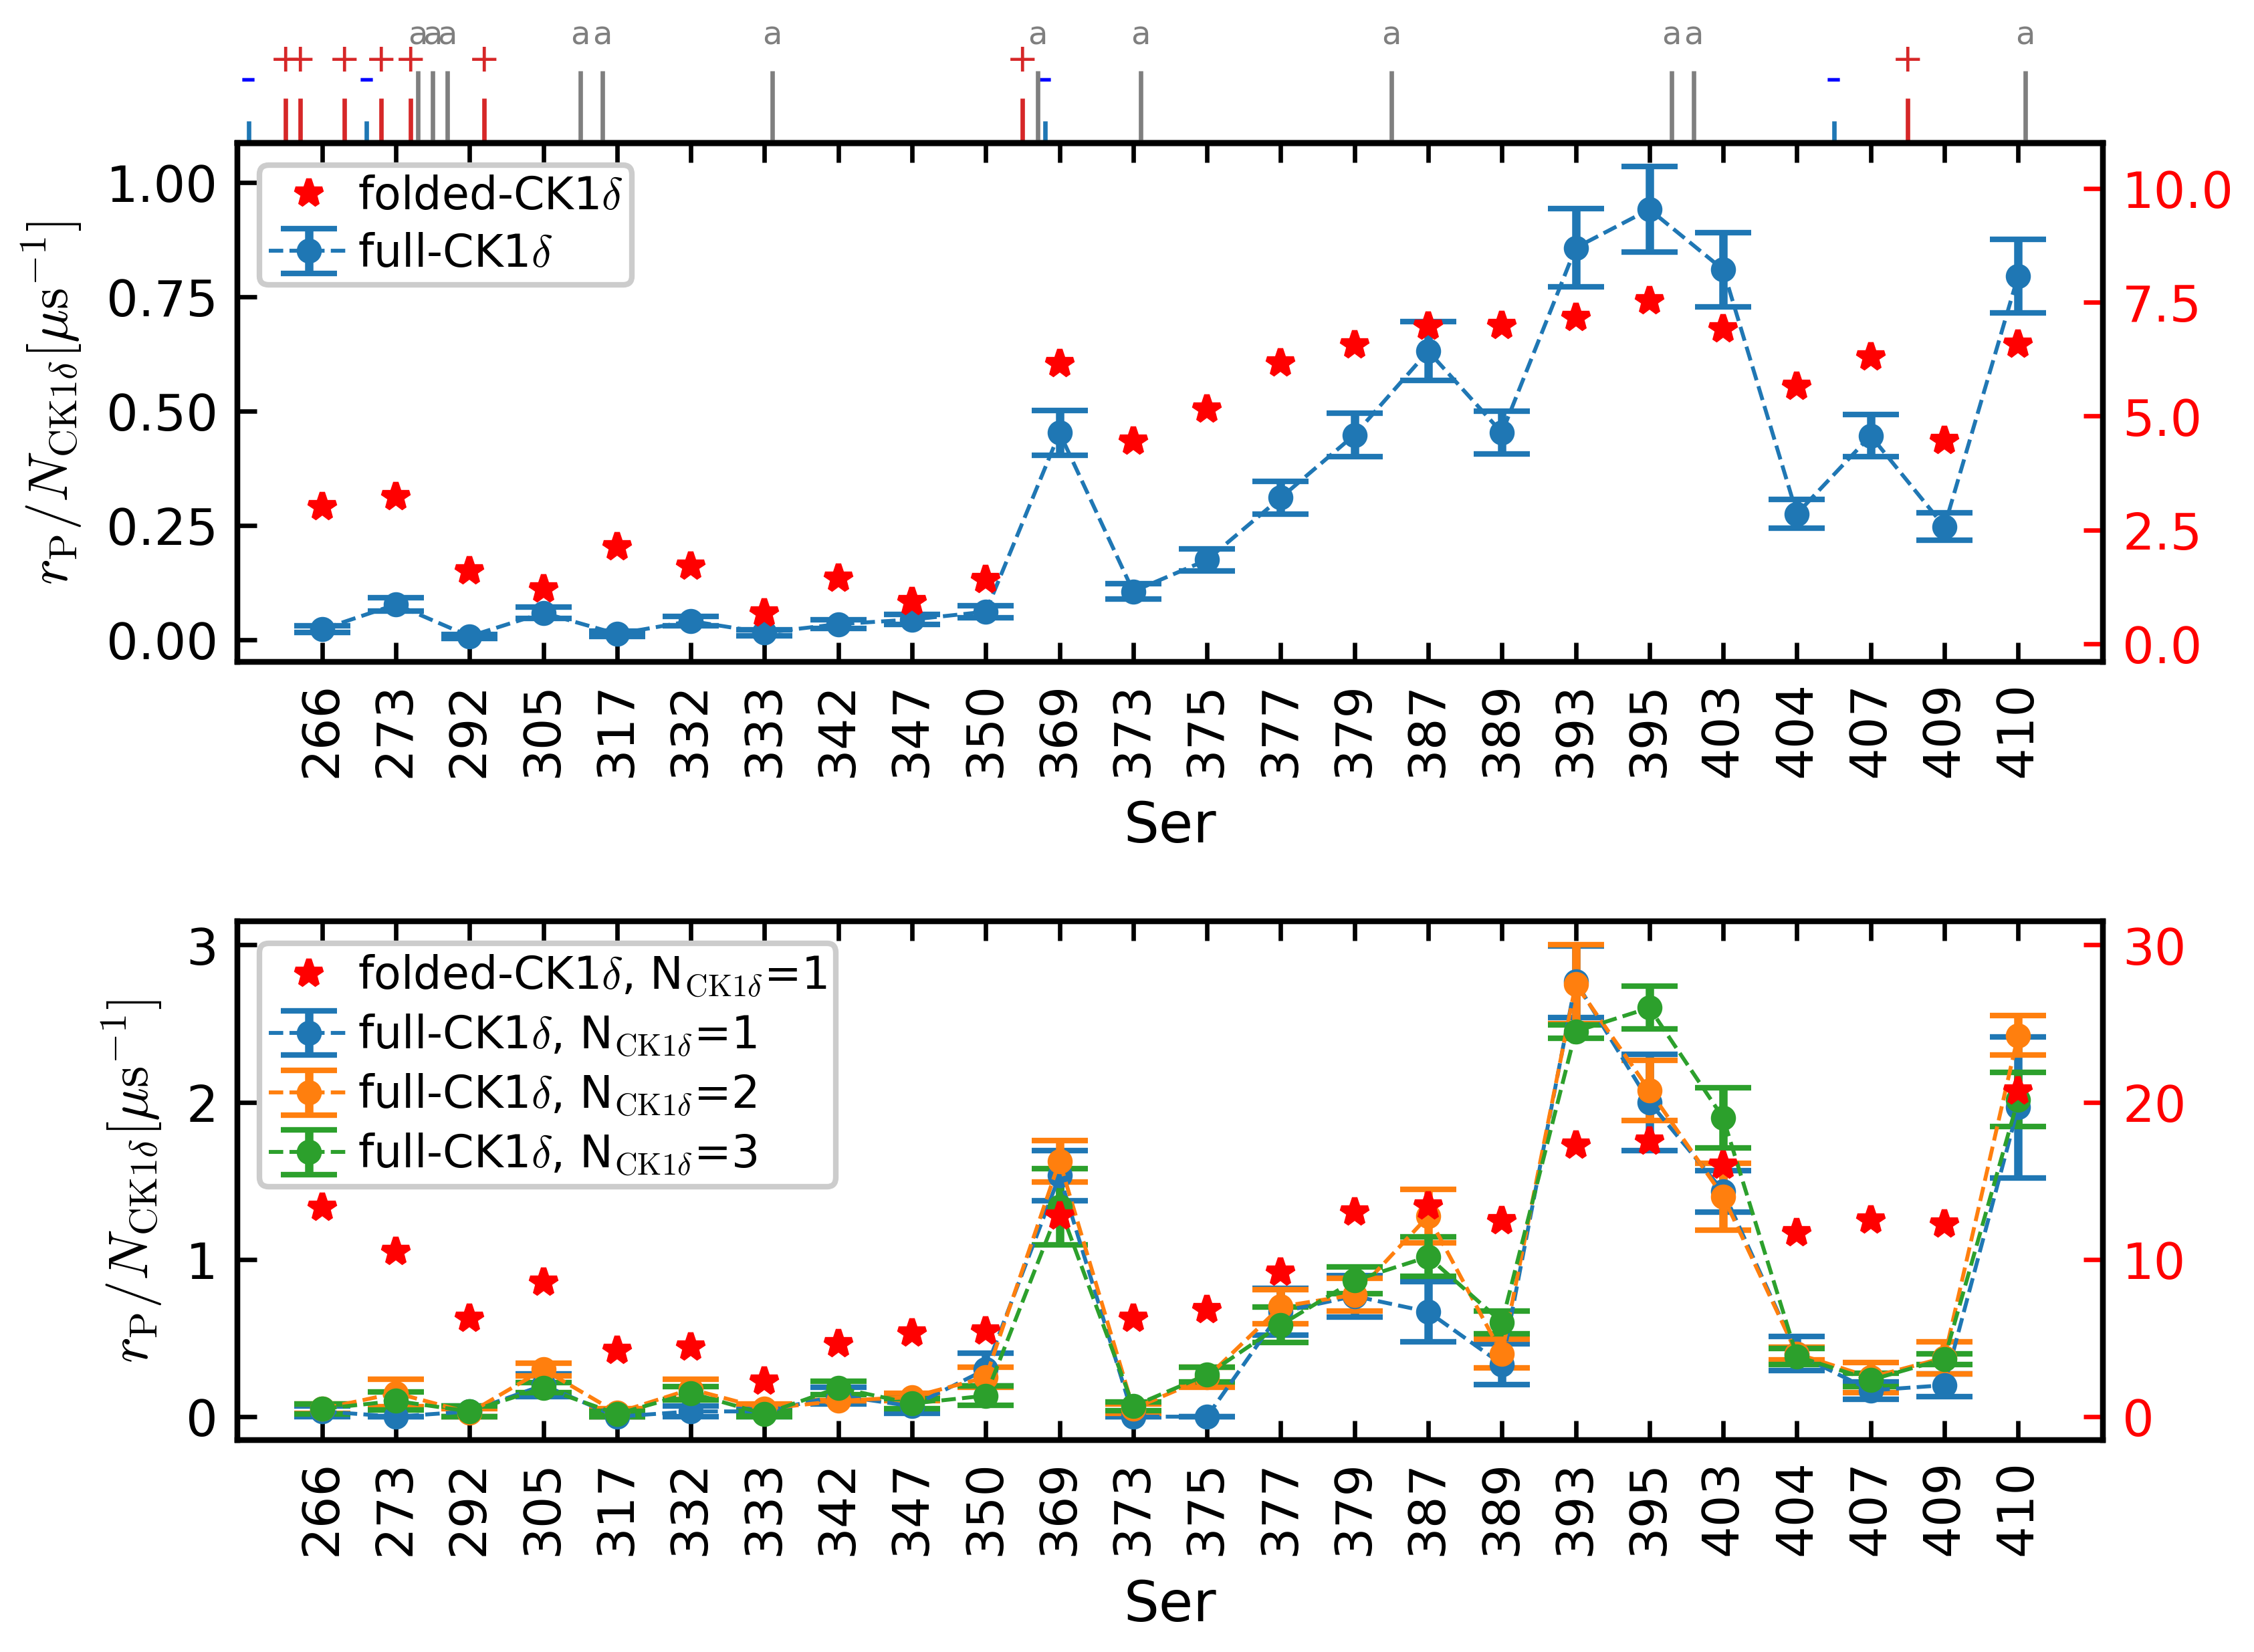

In [258]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,4.2), gridspec_kw={'height_ratios': [1, 1]})
plt.subplots_adjust(hspace=0.5)

ax1.errorbar(np.arange(1,25), rates_f, drates_f, fmt='.--', color='tab:blue', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r'full-CK1$\delta$')
ax1.plot([], [], '*' ,color='r', ms=5, label=r"folded-CK1$\delta$")

ax11 = ax1.twinx()
ax11.plot(np.arange(1,25), rates, '*', ms=5, color='r')
ax11.tick_params(colors='r' )
ax11.set_ylim((-0.4,11))

ax2.errorbar(np.arange(1,25), rp_1c_full, drp_1c_full, fmt='.--', color='tab:blue', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"full-CK1$\delta$, N$_{\mathrm{CK1\delta}}$=1")
ax2.errorbar(np.arange(1,25), rp_2c_full, drp_2c_full, fmt='.--', color='tab:orange', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"full-CK1$\delta$, N$_{\mathrm{CK1\delta}}$=2")
ax2.errorbar(np.arange(1,25), rp_3c_full, drp_3c_full, fmt='.--', color='tab:green', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"full-CK1$\delta$, N$_{\mathrm{CK1\delta}}$=3")
ax2.plot([], [], '*' ,color='r', ms=5, label=r"folded-CK1$\delta$, N$_{\mathrm{CK1\delta}}$=1")

ax21 = ax2.twinx()
ax21.plot(np.arange(1,25), rp_1c_fold, '*', ms=5, color='r')
ax21.tick_params(colors='r' )
ax21.set_ylim((-1.5,31.5))

ax1.set_xticks(np.arange(1,25) , ser_i+260, rotation="vertical" )
ax2.set_xticks(np.arange(1,25) , ser_i+260, rotation="vertical" )
ax1.tick_params( direction='in', top=True, right=False)  # don't put tick labels at the top
ax2.tick_params(direction='in', top=True, right=False)  # don't put tick labels at the top

ax1.legend(loc='upper left', framealpha=1)
ax2.legend(framealpha=1)

ax1.set_xlabel('Ser')
ax2.set_xlabel('Ser')

ax1.set_ylabel('$r_{\mathrm{P}}/N_{\mathrm{CK1\delta}} [\mathrm{\mu s}^{-1}]$')
ax2.set_ylabel('$r_{\mathrm{P}}/N_{\mathrm{CK1\delta}} [\mathrm{\mu s}^{-1}]$')

secax = ax1.secondary_xaxis('top')
secax.set_xticks([0.5, 0.7, 1.3, 1.8, 2.2, 3.2, 10.5, 22.5], ['+']*8, color='tab:red', fontsize='x-small' )
secax.tick_params(direction='out', color='tab:red' , length=8)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([0., 1.6, 10.8, 21.5], ['-']*4, color='blue', fontsize='small' )
secax2.tick_params(direction='out', color='tab:blue' , length=4)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([2.3,2.5,2.7,4.5, 4.8,7.1, 10.7, 12.1, 15.5, 19.3, 19.6, 24.1], ['a']*12, color='tab:grey', fontsize='xx-small' )
secax2.tick_params(direction='out', color='tab:grey' , length=13)

plt.show()

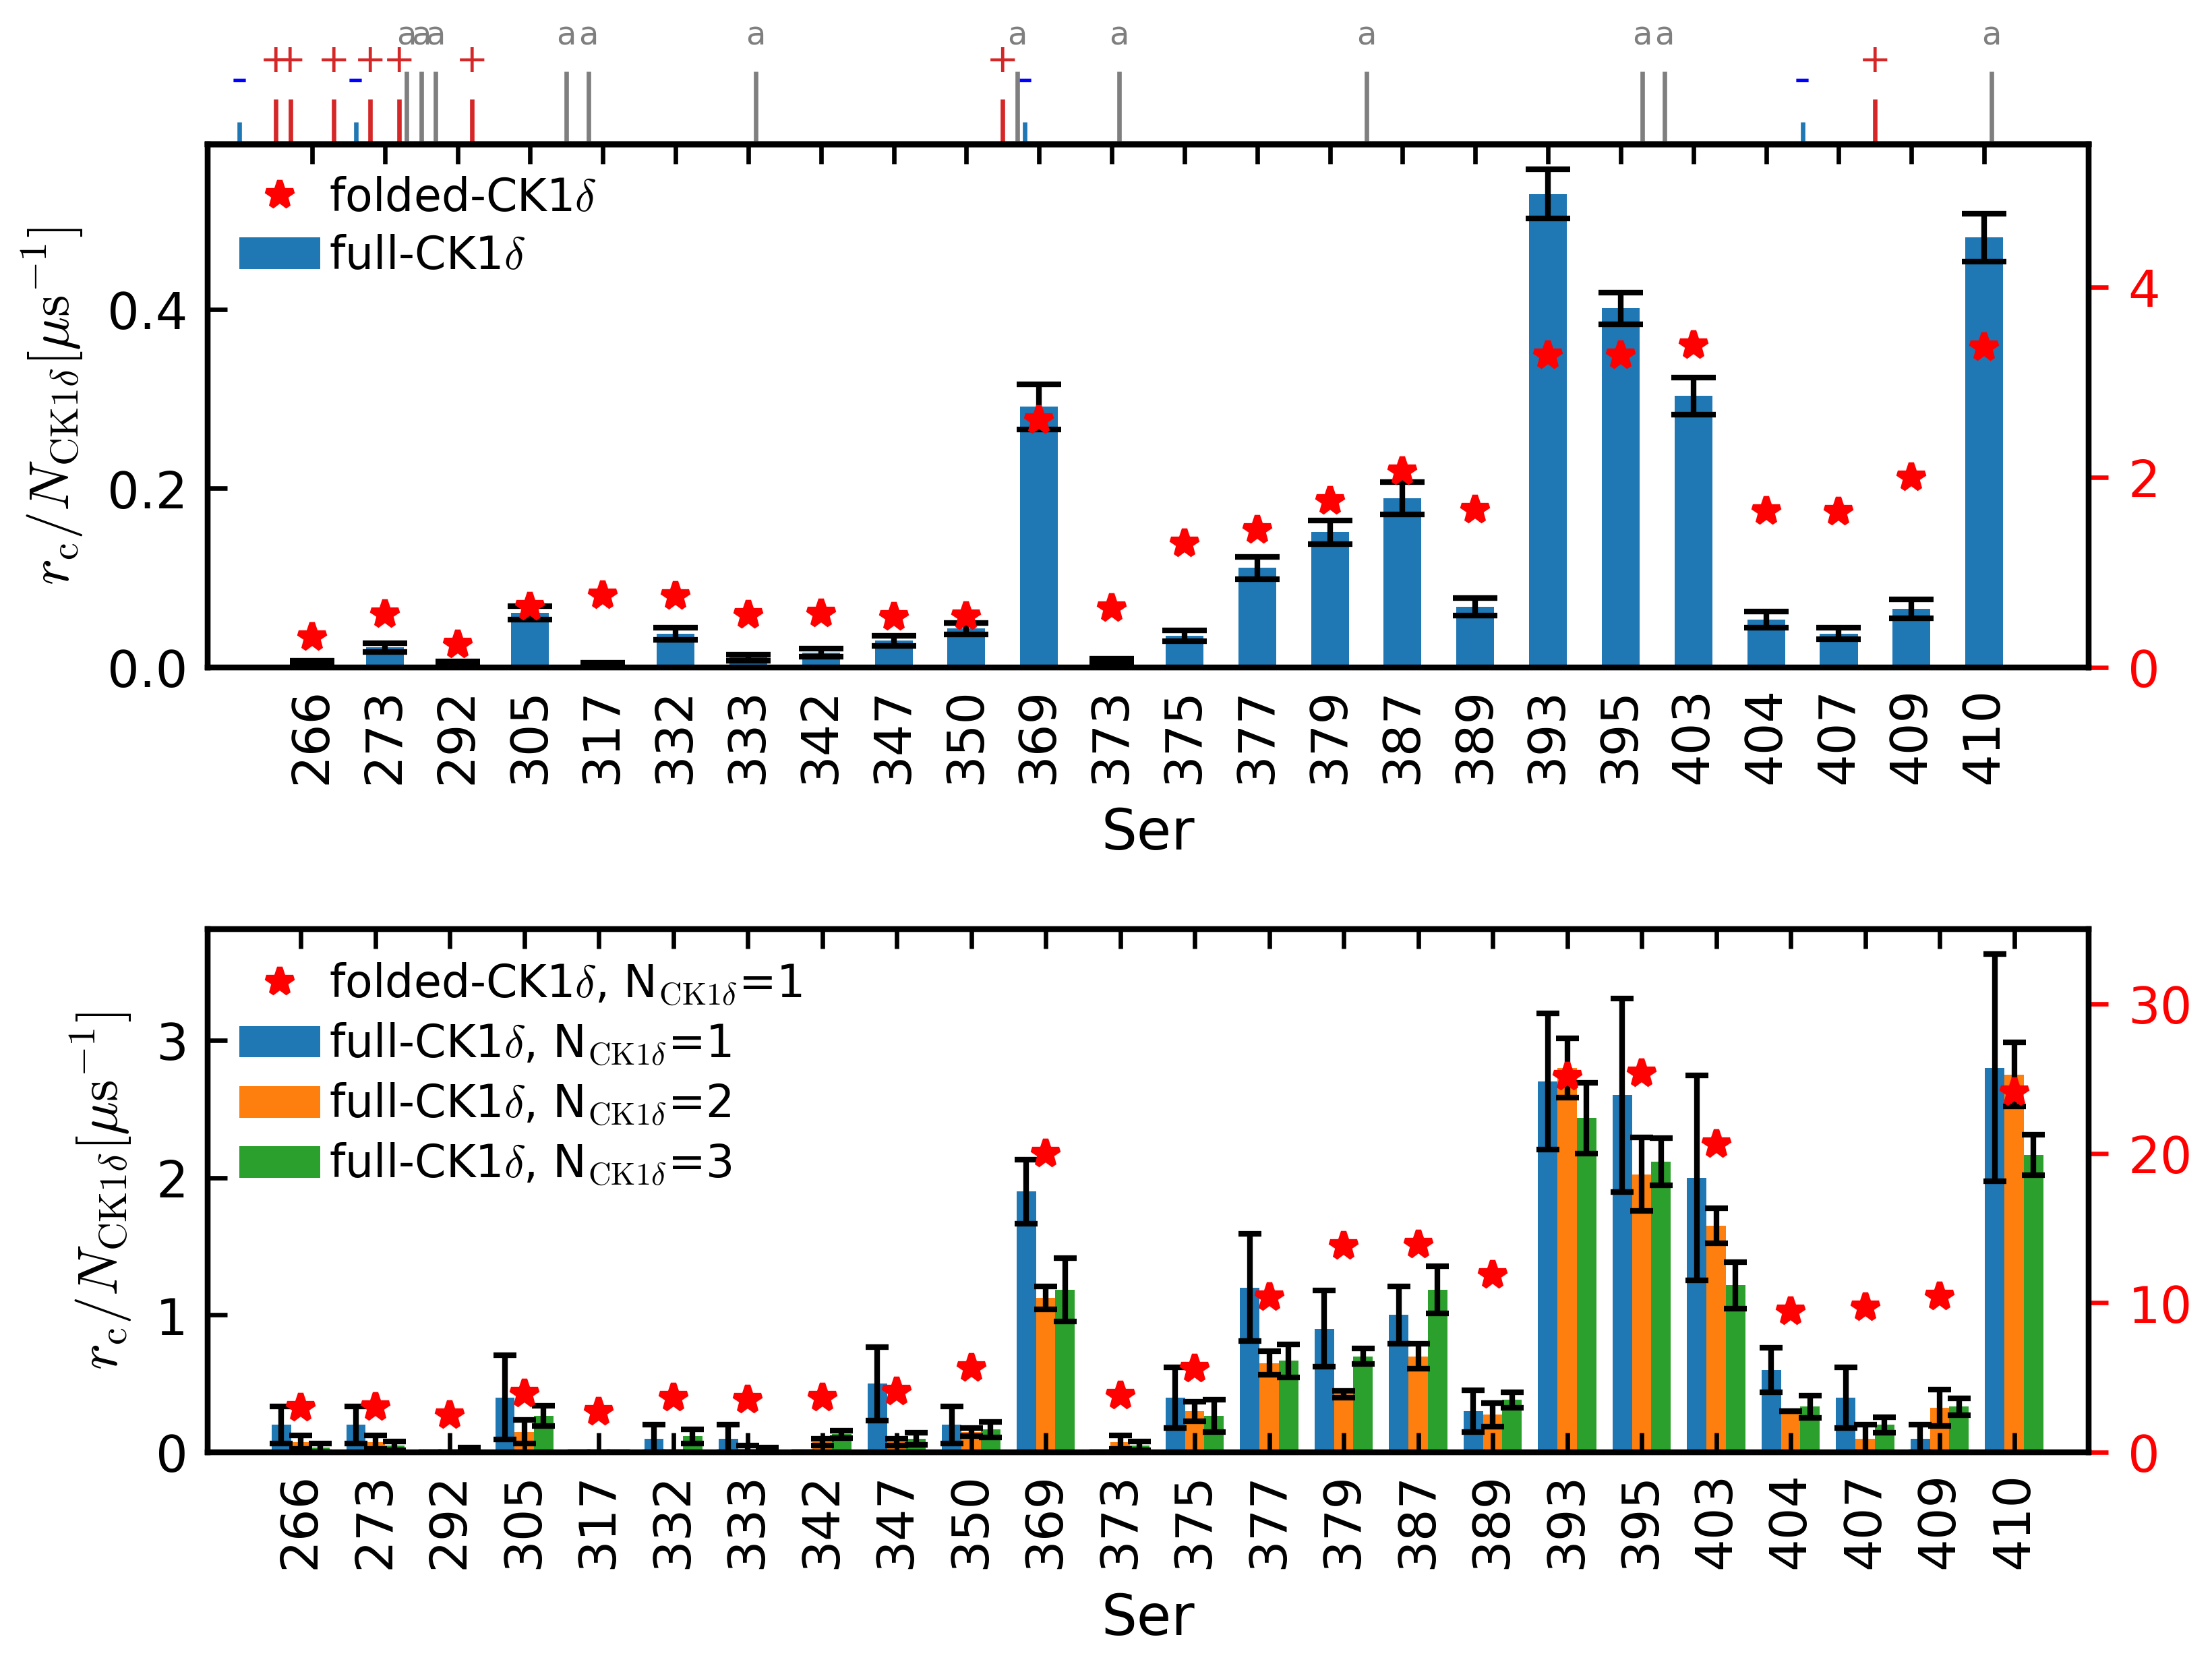

In [275]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,4.2), gridspec_kw={'height_ratios': [1, 1]})
shift = 0.26

ax1.set_ylabel(r"$r_{\mathrm{c}}/N_{\mathrm{CK1\delta}} [\mathrm{\mu s^{-1}}]$")
ax2.set_ylabel(r"$r_{\mathrm{c}}/N_{\mathrm{CK1\delta}} [\mathrm{\mu s^{-1}}]$")
plt.xlim(-0.25,25)
plt.subplots_adjust(hspace=0.5)

ax1.bar(np.arange(1,25), rc_f, color='tab:blue', yerr=drc_f, width=shift*2, capsize=4, label=r"full-CK1$\delta$")
ax1.plot([], [], '*' ,color='r', ms=5, label=r"folded-CK1$\delta$")

ax11 = ax1.twinx()
ax11.plot(np.arange(1,25), rc, '*', ms=5, color='r')
ax11.tick_params(colors='r' )
ax11.set_ylim((0,5.5)) #count_average_c[19]+3*count_err_c[19]))

ax2.bar(np.arange(1,25)-shift, rc_1c_full, yerr=drc_1c_full, width=shift, color='tab:blue', capsize=2, label=r'full-CK1$\delta$, N$_{\mathrm{CK1\delta}}$=1')
ax2.bar(np.arange(1,25), rc_2c_full, yerr=drc_2c_full, width=shift, color='tab:orange', capsize=2, label=r"full-CK1$\delta$, N$_{\mathrm{CK1\delta}}$=2")
ax2.bar(np.arange(1,25)+shift, rc_3c_full, yerr=drc_3c_full, width=shift, color='tab:green', capsize=2, label=r"full-CK1$\delta$, N$_{\mathrm{CK1\delta}}$=3")
ax2.plot([], [], '*', color='r', ms=5, label=r"folded-CK1$\delta$, N$_{\mathrm{CK1\delta}}$=1")

ax21 = ax2.twinx()
ax21.plot(np.arange(1,25), rc_1c_fold, '*', ms=5, color='r')
ax21.tick_params(colors='r' )
ax21.set_ylim((0,35))  #count_average_np_r3_fold[18]+3*std_err_np_fold[18]))

ax1.set_xticks(np.arange(1,25) , ser_i+260 , rotation="vertical" )
ax2.set_xticks(np.arange(1,25) , ser_i+260 , rotation="vertical" )
ax2.set_xlabel("Ser")
ax1.set_xlabel("Ser")

ax2.set_xticks(np.arange(1,25) , ser_i+260, rotation="vertical" )
ax1.tick_params( direction='in', bottom=False, top=True, right=False)  # don't put tick labels at the top
ax2.tick_params(direction='in', top=True, right=False)  # don't put tick labels at the top

ax1.legend(loc='upper left', framealpha=1)
ax2.legend(loc='upper left', framealpha=1)

secax = ax1.secondary_xaxis('top')
secax.set_xticks([0.5, 0.7, 1.3, 1.8, 2.2, 3.2, 10.5, 22.5], ['+']*8, color='tab:red', fontsize='x-small' )
secax.tick_params(direction='out', color='tab:red' , length=8)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([0., 1.6, 10.8, 21.5], ['-']*4, color='blue', fontsize='small' )
secax2.tick_params(direction='out', color='tab:blue' , length=4)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([2.3,2.5,2.7,4.5, 4.8,7.1, 10.7, 12.1, 15.5, 19.3, 19.6, 24.1], ['a']*12, color='tab:grey', fontsize='xx-small' )
secax2.tick_params(direction='out', color='tab:grey' , length=13)

plt.show()

In [220]:
rp_3c_fold_025_05, drp_3c_fold_025_05 = count_contacts(dirpath='', file_suffix='3-folded-ck1d_multi-tdp43_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, type_of_contact=1, len_prot=154, n_prot=200, start=0.25*10**8, end=0.5*10**8)
rp_3c_fold_025_05 /= 3  # kinases
drp_3c_fold_025_05/= 3  # kinases
rp_3c_fold_025_05 /= 0.25  # \mu s
drp_3c_fold_025_05/= 0.25  # \mu s

rp_3c_fold_05_075, drp_3c_fold_05_075 = count_contacts(dirpath='', file_suffix='3-folded-ck1d_multi-tdp43_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, type_of_contact=1, len_prot=154, n_prot=200, start=0.5*10**8, end=0.75*10**8)
rp_3c_fold_05_075 /= 3  # kinases
drp_3c_fold_05_075/= 3  # kinases
rp_3c_fold_05_075 /= 0.25  # \mu s
drp_3c_fold_05_075/= 0.25  # \mu s

rp_3c_fold_075_1, drp_3c_fold_075_1 = count_contacts(dirpath='', file_suffix='3-folded-ck1d_multi-tdp43_32b_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=4, type_of_contact=1, len_prot=154, n_prot=200, start=0.75*10**8, end=10**8)
rp_3c_fold_075_1 /= 3  # kinases
drp_3c_fold_075_1/= 3  # kinases
rp_3c_fold_075_1 /= 0.25  # \mu s
drp_3c_fold_075_1/= 0.25  # \mu s


rp_3c_full_0_5, drp_3c_full_0_5 = count_contacts(dirpath='', file_suffix='3-full-ck1d_multi-tdp43_32b_25us_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=[0,2], type_of_contact=1, len_prot=154, n_prot=200, start=0, end=5*10**8)
rp_3c_full_0_5 /= 3  # kinases
drp_3c_full_0_5/= 3  # kinases
rp_3c_full_0_5 /= 5  # \mu s
drp_3c_full_0_5/= 5  # \mu s

rp_3c_full_5_10, drp_3c_full_5_10 = count_contacts(dirpath='', file_suffix='3-full-ck1d_multi-tdp43_32b_25us_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=[0,2], type_of_contact=1, len_prot=154, n_prot=200, start=5*10**8, end=10**9)
rp_3c_full_5_10 /= 3  # kinases
drp_3c_full_5_10/= 3  # kinases
rp_3c_full_5_10 /= 5  # \mu s
drp_3c_full_5_10/= 5  # \mu s

rp_3c_full_10_15, drp_3c_full_10_15 = count_contacts(dirpath='', file_suffix='3-full-ck1d_multi-tdp43_32b_25us_contacts.txt',
                                                  ser_l=ser_i-1, n_sims=[0,2], type_of_contact=1, len_prot=154, n_prot=200, start=10**9, end=15*10**8)
rp_3c_full_10_15 /= 3  # kinases
drp_3c_full_10_15/= 3  # kinases
rp_3c_full_10_15 /= 5  # \mu s
drp_3c_full_10_15/= 5  # \mu s


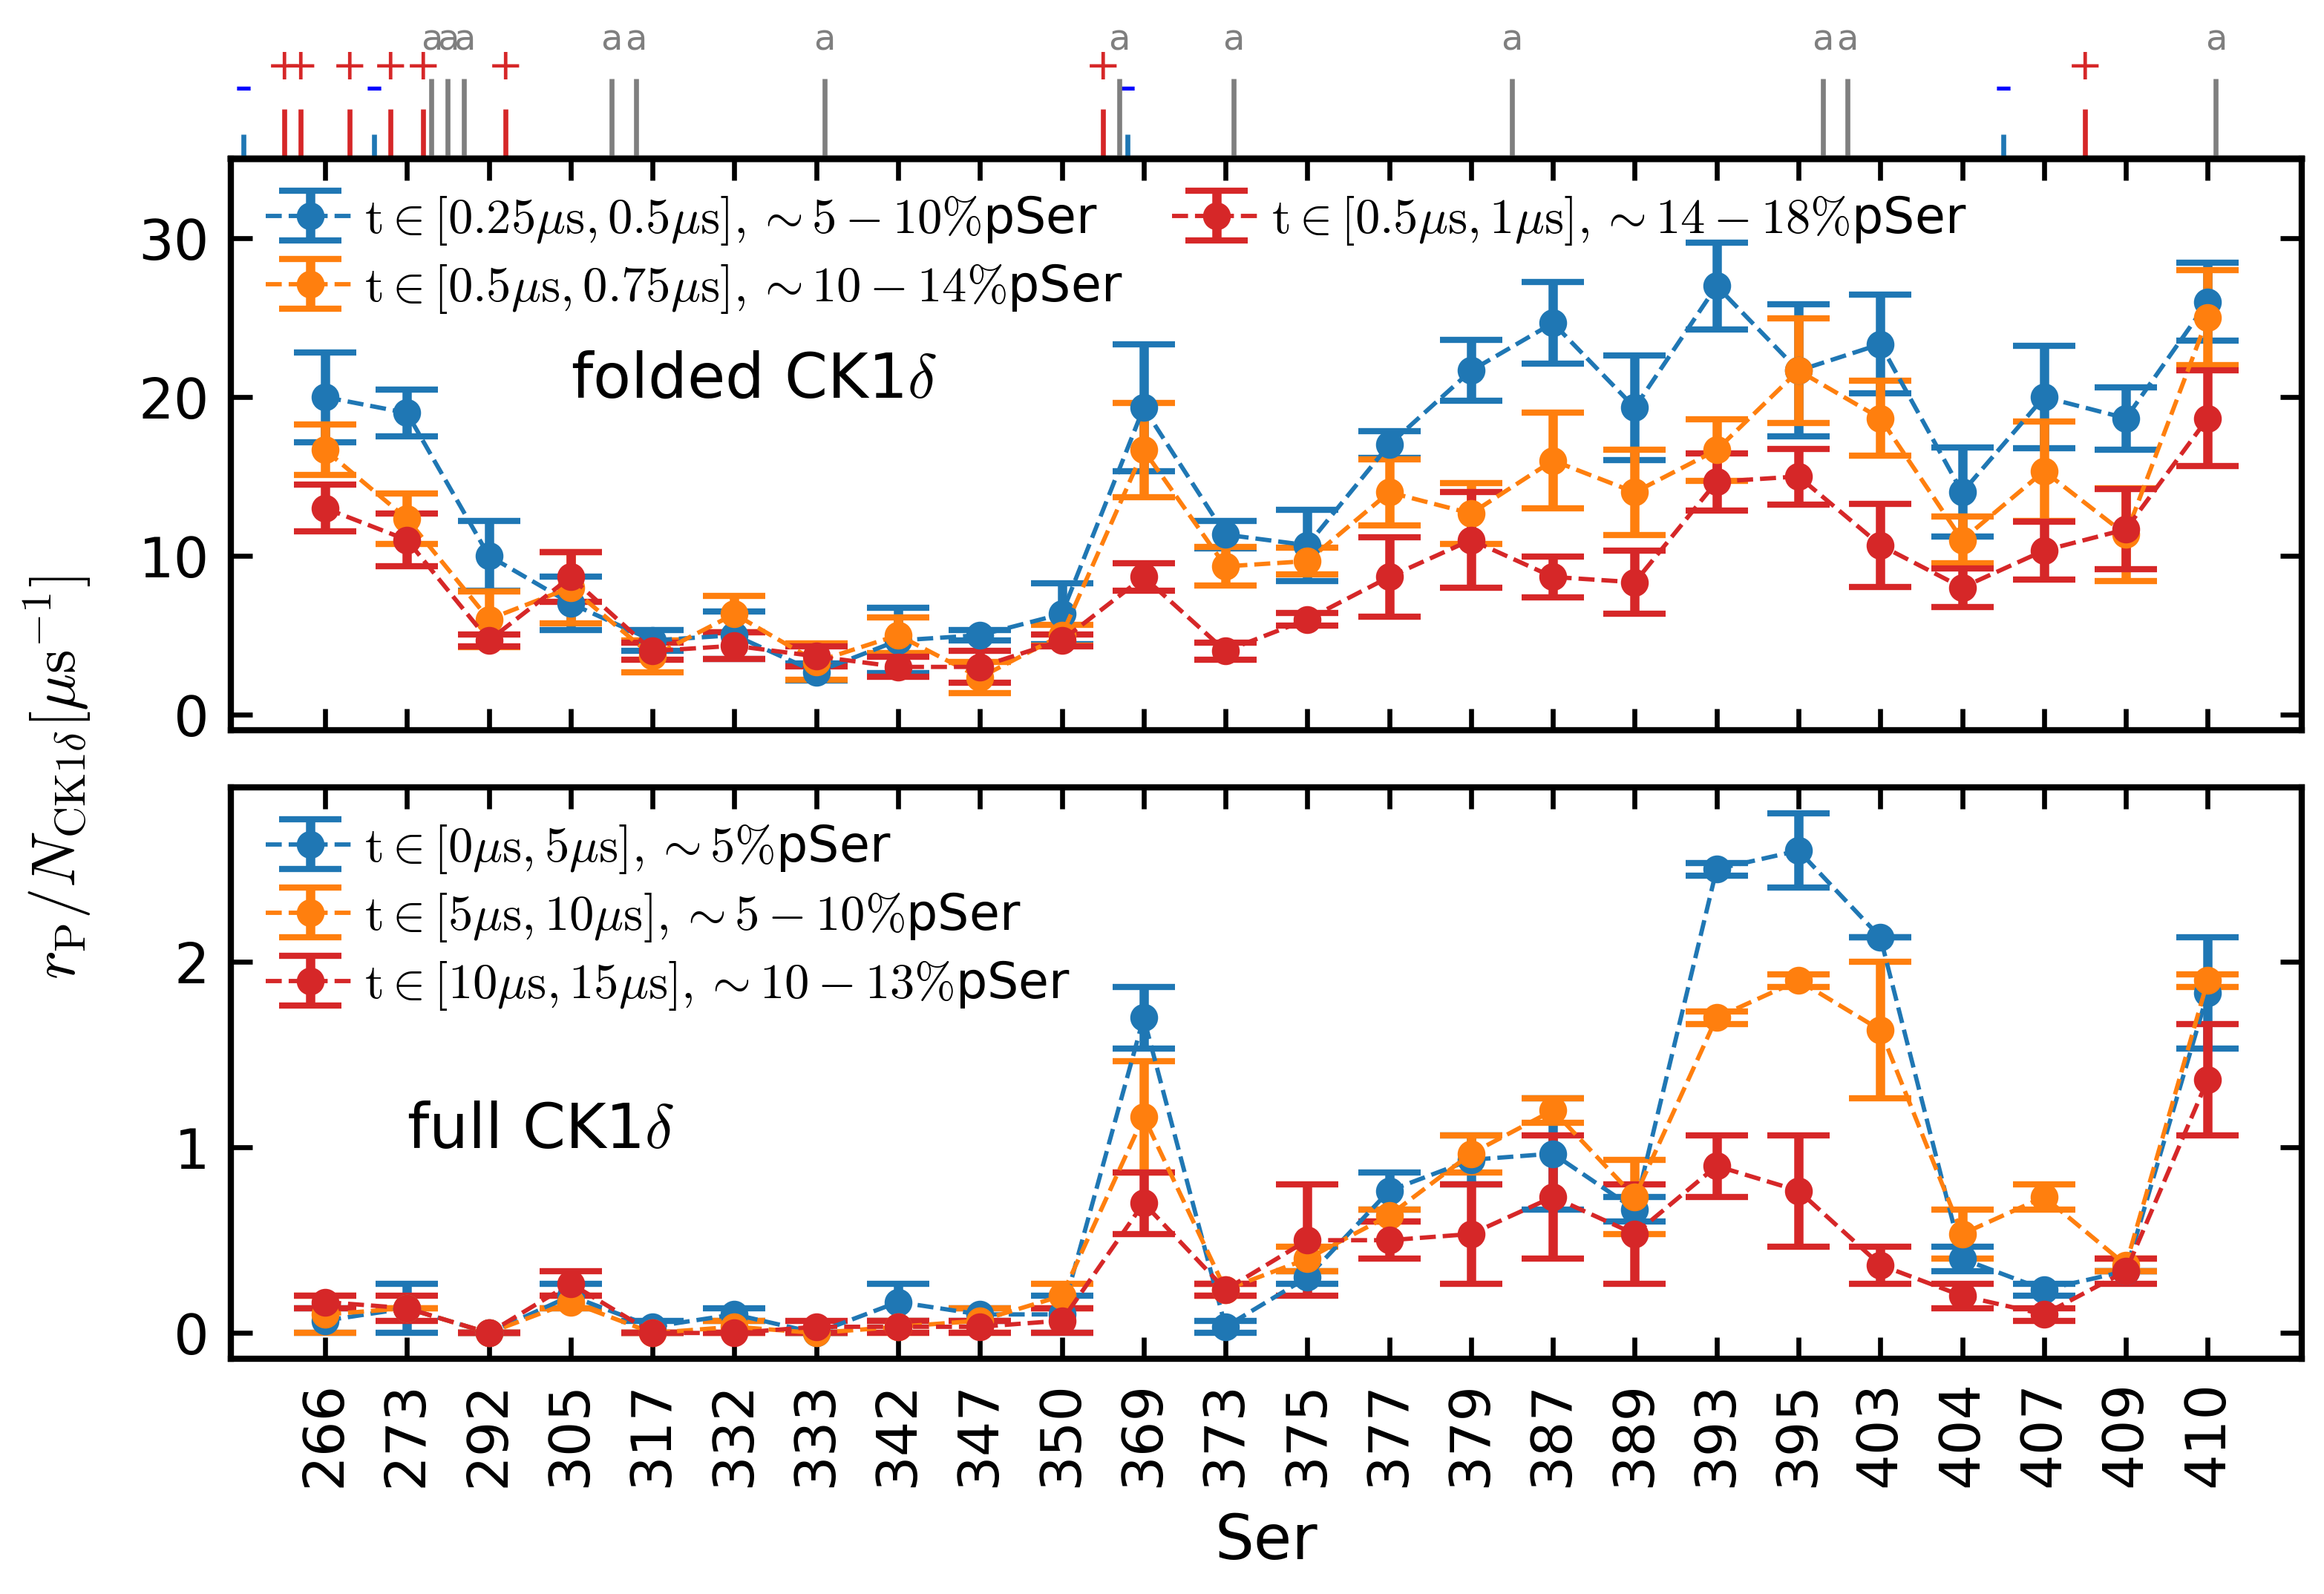

In [221]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,3.5), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
plt.subplots_adjust(hspace=0.1)

ax1.errorbar(np.arange(1,25), rp_3c_fold_025_05, drp_3c_fold_025_05, fmt='.--', color='tab:blue', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"$\mathrm{t \in [0.25\mu s,0.5\mu s]}, \sim 5-10\%$pSer")
ax1.errorbar(np.arange(1,25), rp_3c_fold_05_075, drp_3c_fold_05_075, fmt='.--', color='tab:orange', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"$\mathrm{t \in [0.5\mu s,0.75\mu s]}, \sim 10-14\%$pSer")
ax1.errorbar(np.arange(1,25), rp_3c_fold_075_1, drp_3c_fold_075_1, fmt='.--', color='tab:red', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"$\mathrm{t \in [0.5\mu s,1\mu s]}, \sim 14-18\%$pSer")

ax2.errorbar(np.arange(1,25), rp_3c_full_0_5, drp_3c_full_0_5, fmt='.--', color='tab:blue', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"$\mathrm{t \in [0\mu s,5\mu s]}, \sim 5\%$pSer")
ax2.errorbar(np.arange(1,25), rp_3c_full_5_10, drp_3c_full_5_10, fmt='.--', color='tab:orange', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"$\mathrm{t \in [5\mu s,10\mu s]}, \sim 5-10\%$pSer")
ax2.errorbar(np.arange(1,25), rp_3c_full_10_15, drp_3c_full_10_15, fmt='.--', color='tab:red', elinewidth=1.5, linewidth=.7, capsize=5, markersize=7,  label=r"$\mathrm{t \in [10\mu s,15\mu s]}, \sim 10-13\%$pSer")

ax2.set_xlabel("Ser")
ax1.set_ylim(-1,35)
ax2.set_xticks(np.arange(1,25) , ser_i+260, rotation="vertical" )
ax1.tick_params( direction='in', top=True, right=True)  # don't put tick labels at the top
ax2.tick_params(direction='in', top=True, right=True)  # don't put tick labels at the top

ax1.legend(loc='upper left', framealpha=0, ncols=2)
ax2.legend(framealpha=0)
ax2.text(-2.7,2.,'$r_{\mathrm{P}}/N_{\mathrm{CK1\delta}} [\mathrm{\mu s}^{-1}]$', rotation='vertical')

secax = ax1.secondary_xaxis('top')
secax.set_xticks([0.5, 0.7, 1.3, 1.8, 2.2, 3.2, 10.5, 22.5], ['+']*8, color='tab:red', fontsize='x-small' )
secax.tick_params(direction='out', color='tab:red' , length=8)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([0., 1.6, 10.8, 21.5], ['-']*4, color='blue', fontsize='small' )
secax2.tick_params(direction='out', color='tab:blue' , length=4)

secax2 = ax1.secondary_xaxis('top')
secax2.set_xticks([2.3,2.5,2.7,4.5, 4.8,7.1, 10.7, 12.1, 15.5, 19.3, 19.6, 24.1], ['a']*12, color='tab:grey', fontsize='xx-small' )
secax2.tick_params(direction='out', color='tab:grey' , length=13)

ax1.text(4,20,'folded CK1$\delta$')
ax2.text(2,1,'full CK1$\delta$')

plt.show()

In [294]:
plt.style.use('default')
plt.style.use('corr_plot.mplstyle')


[407 410]


/tmp/ipykernel_2176651/3911592421.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  color_bar = plt.colorbar(cm.ScalarMappable(norm=norm))


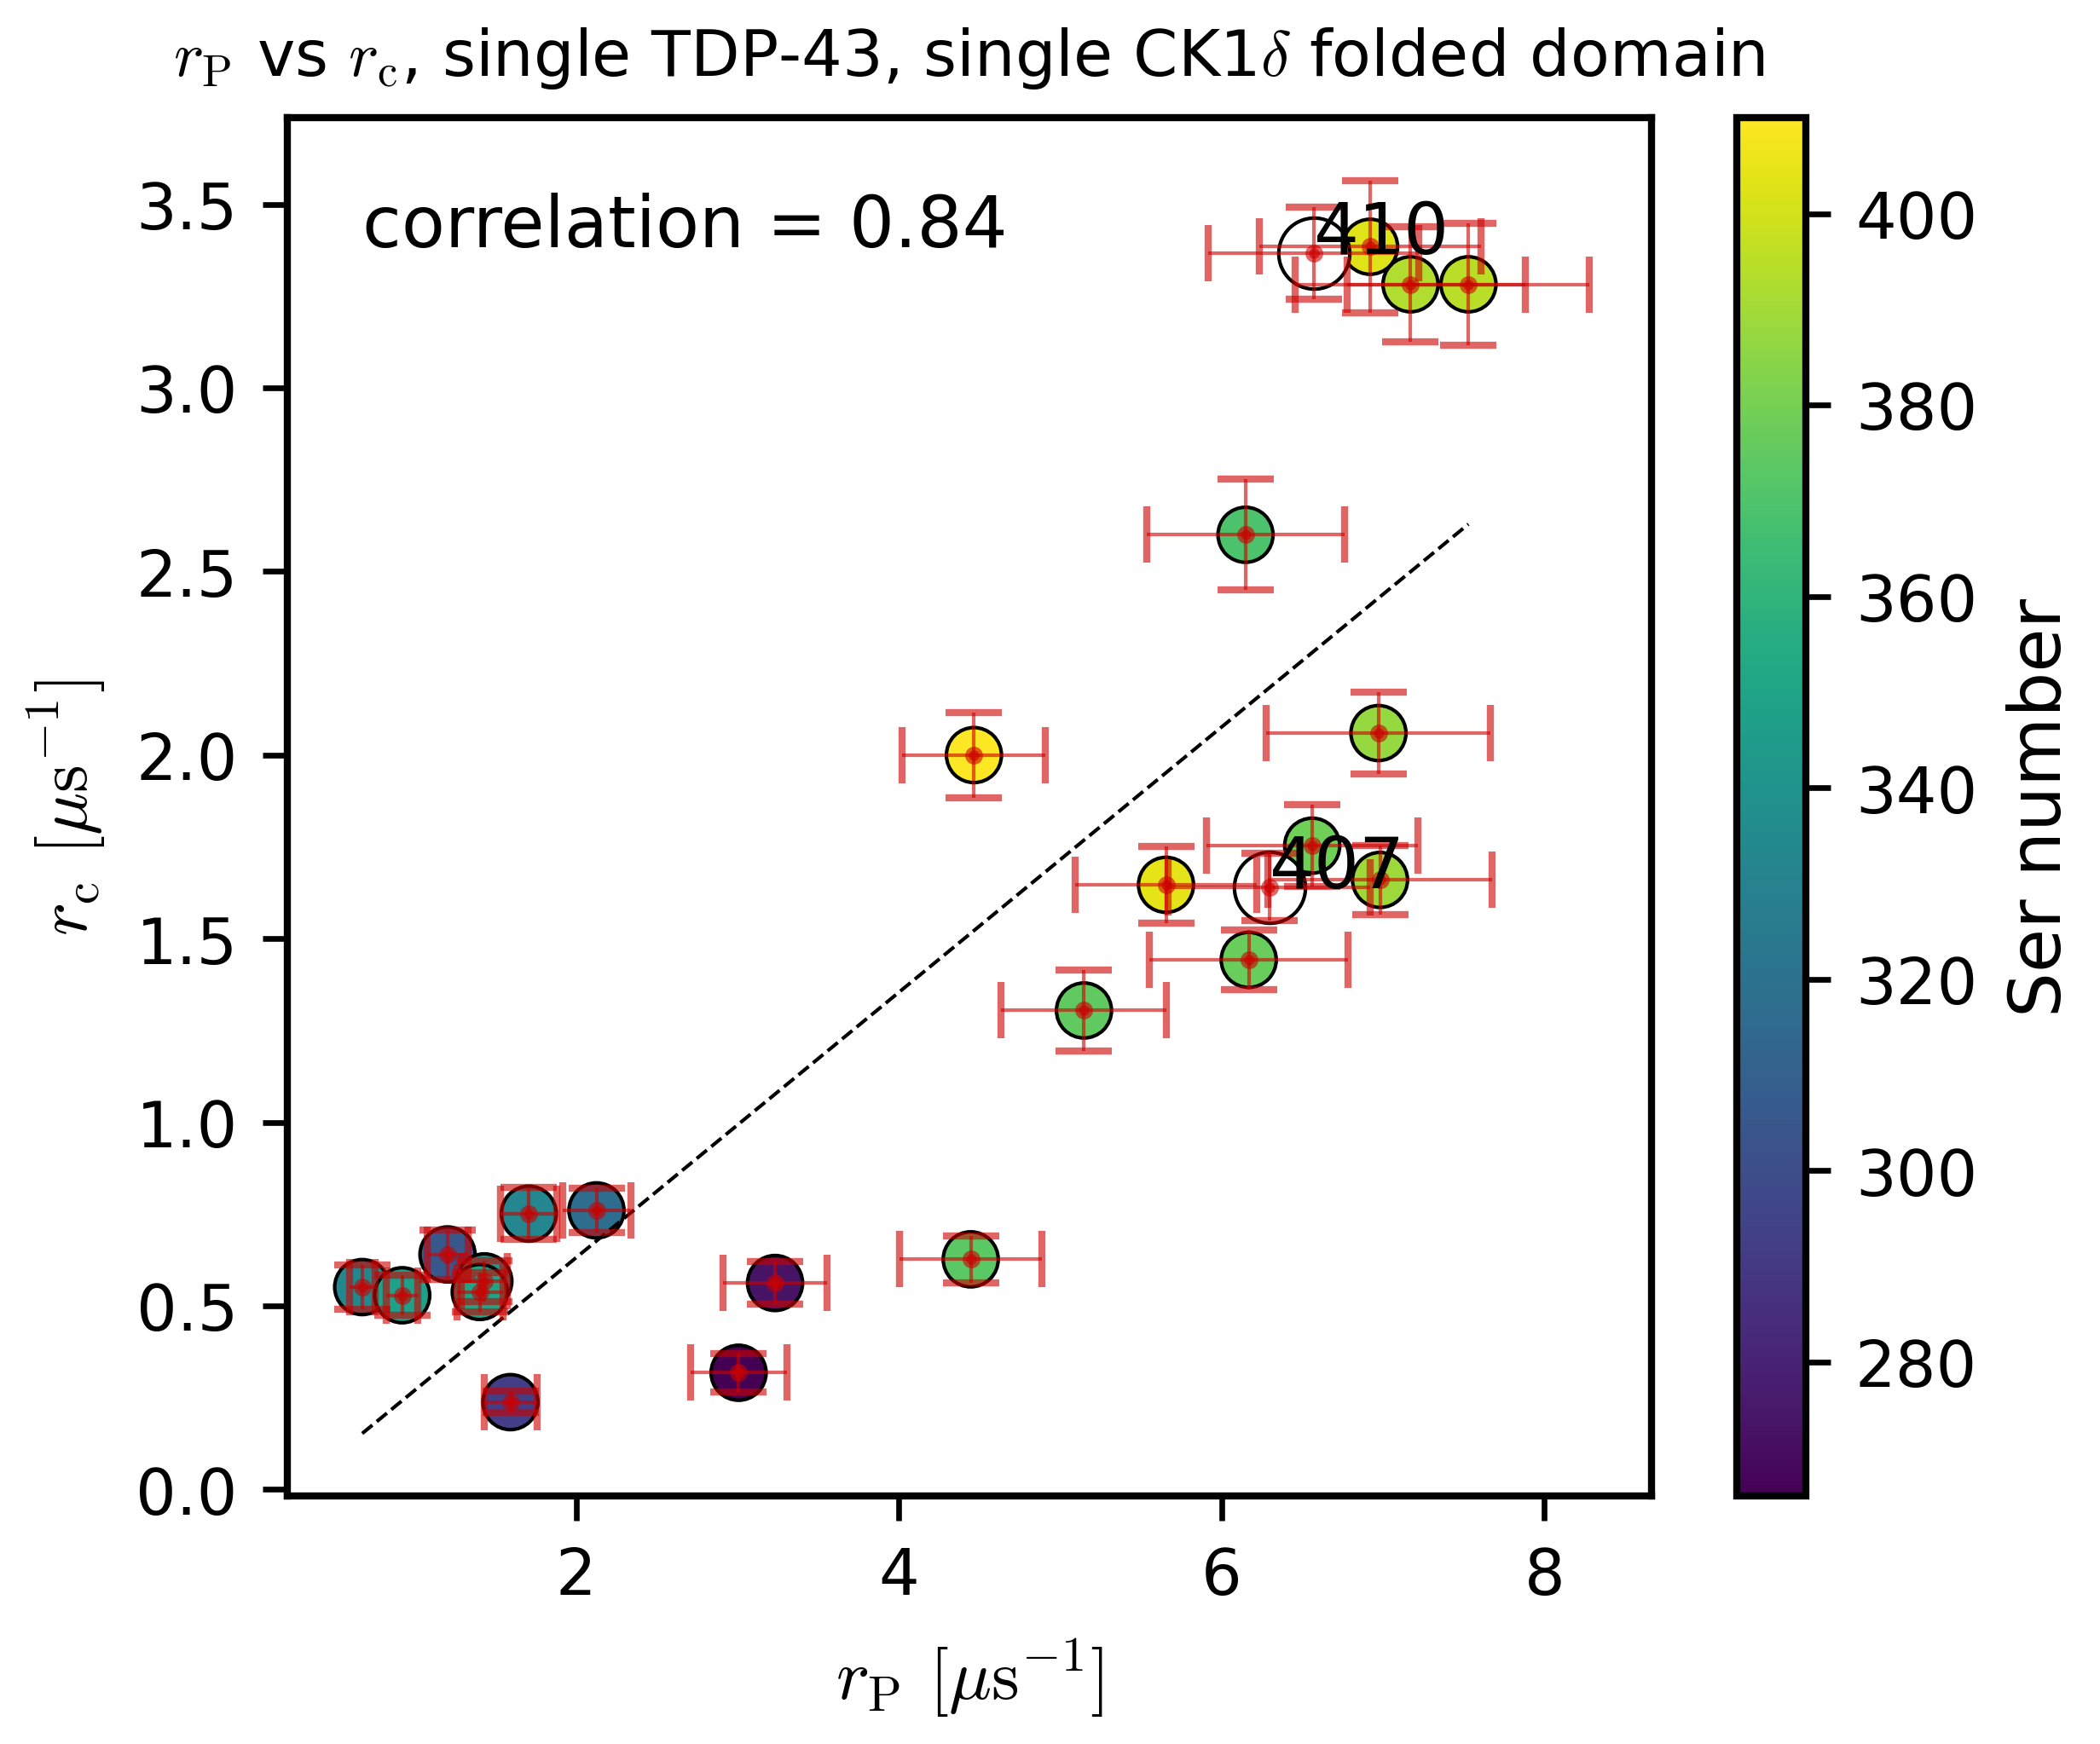

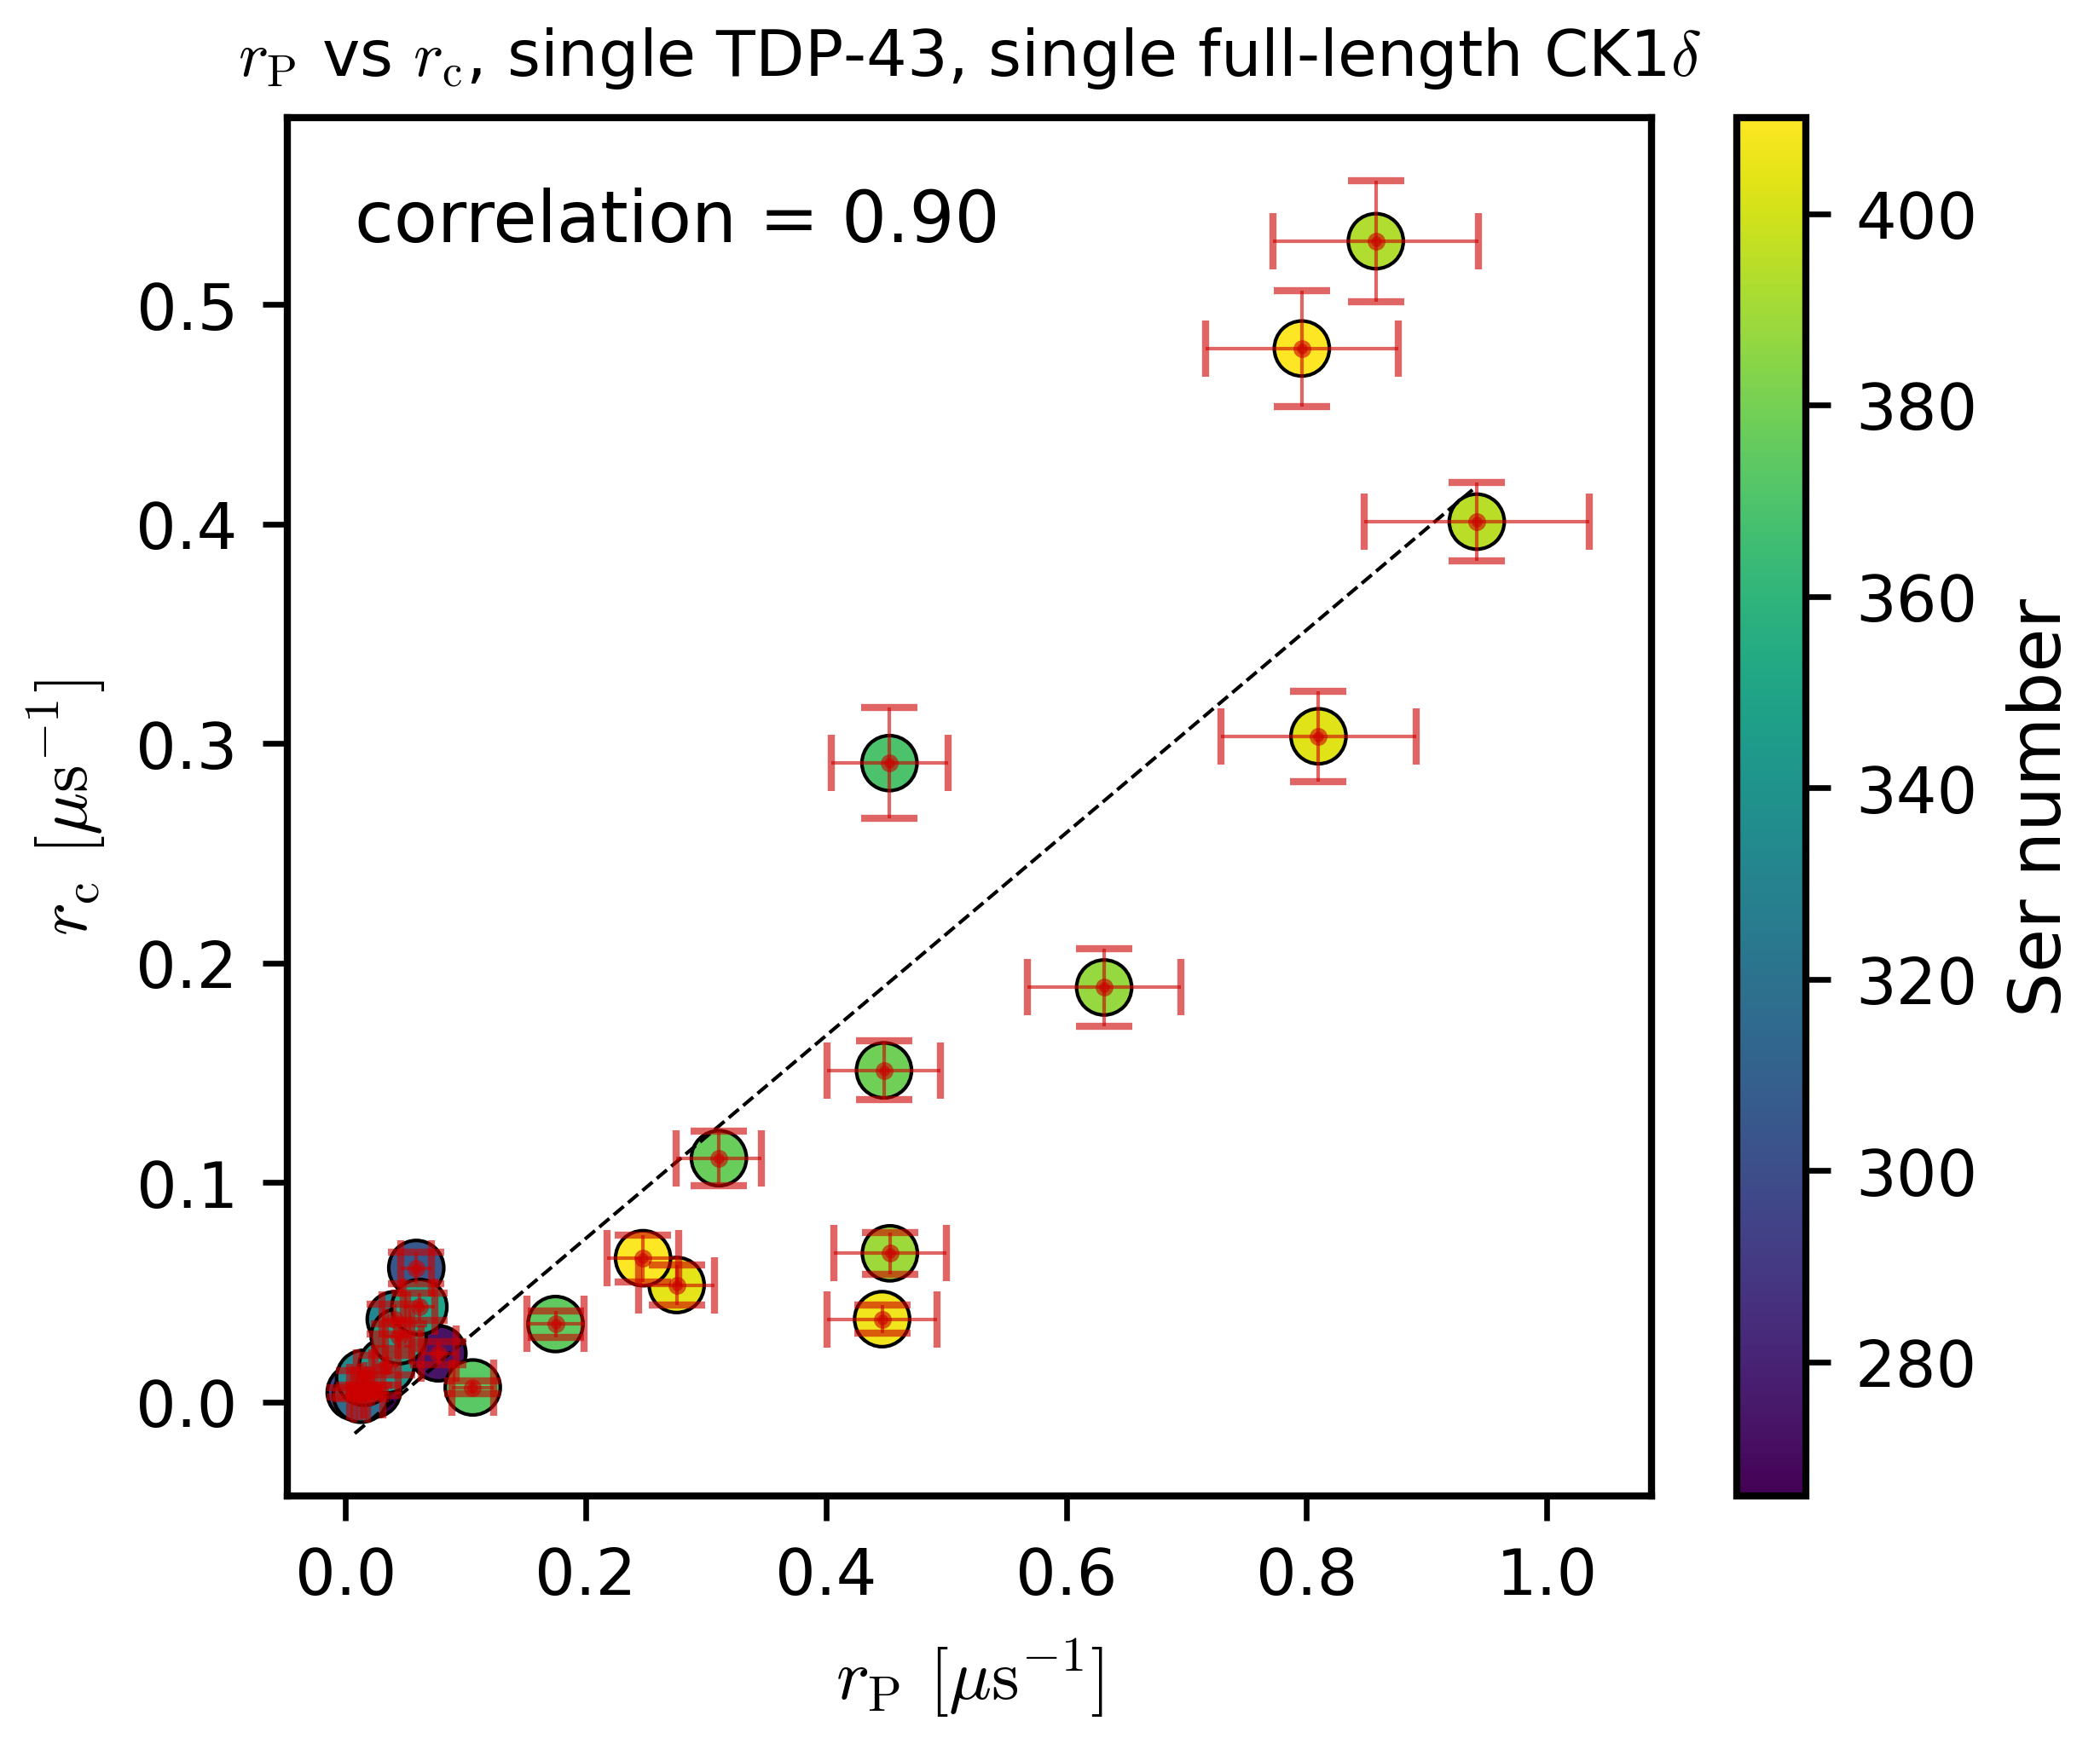

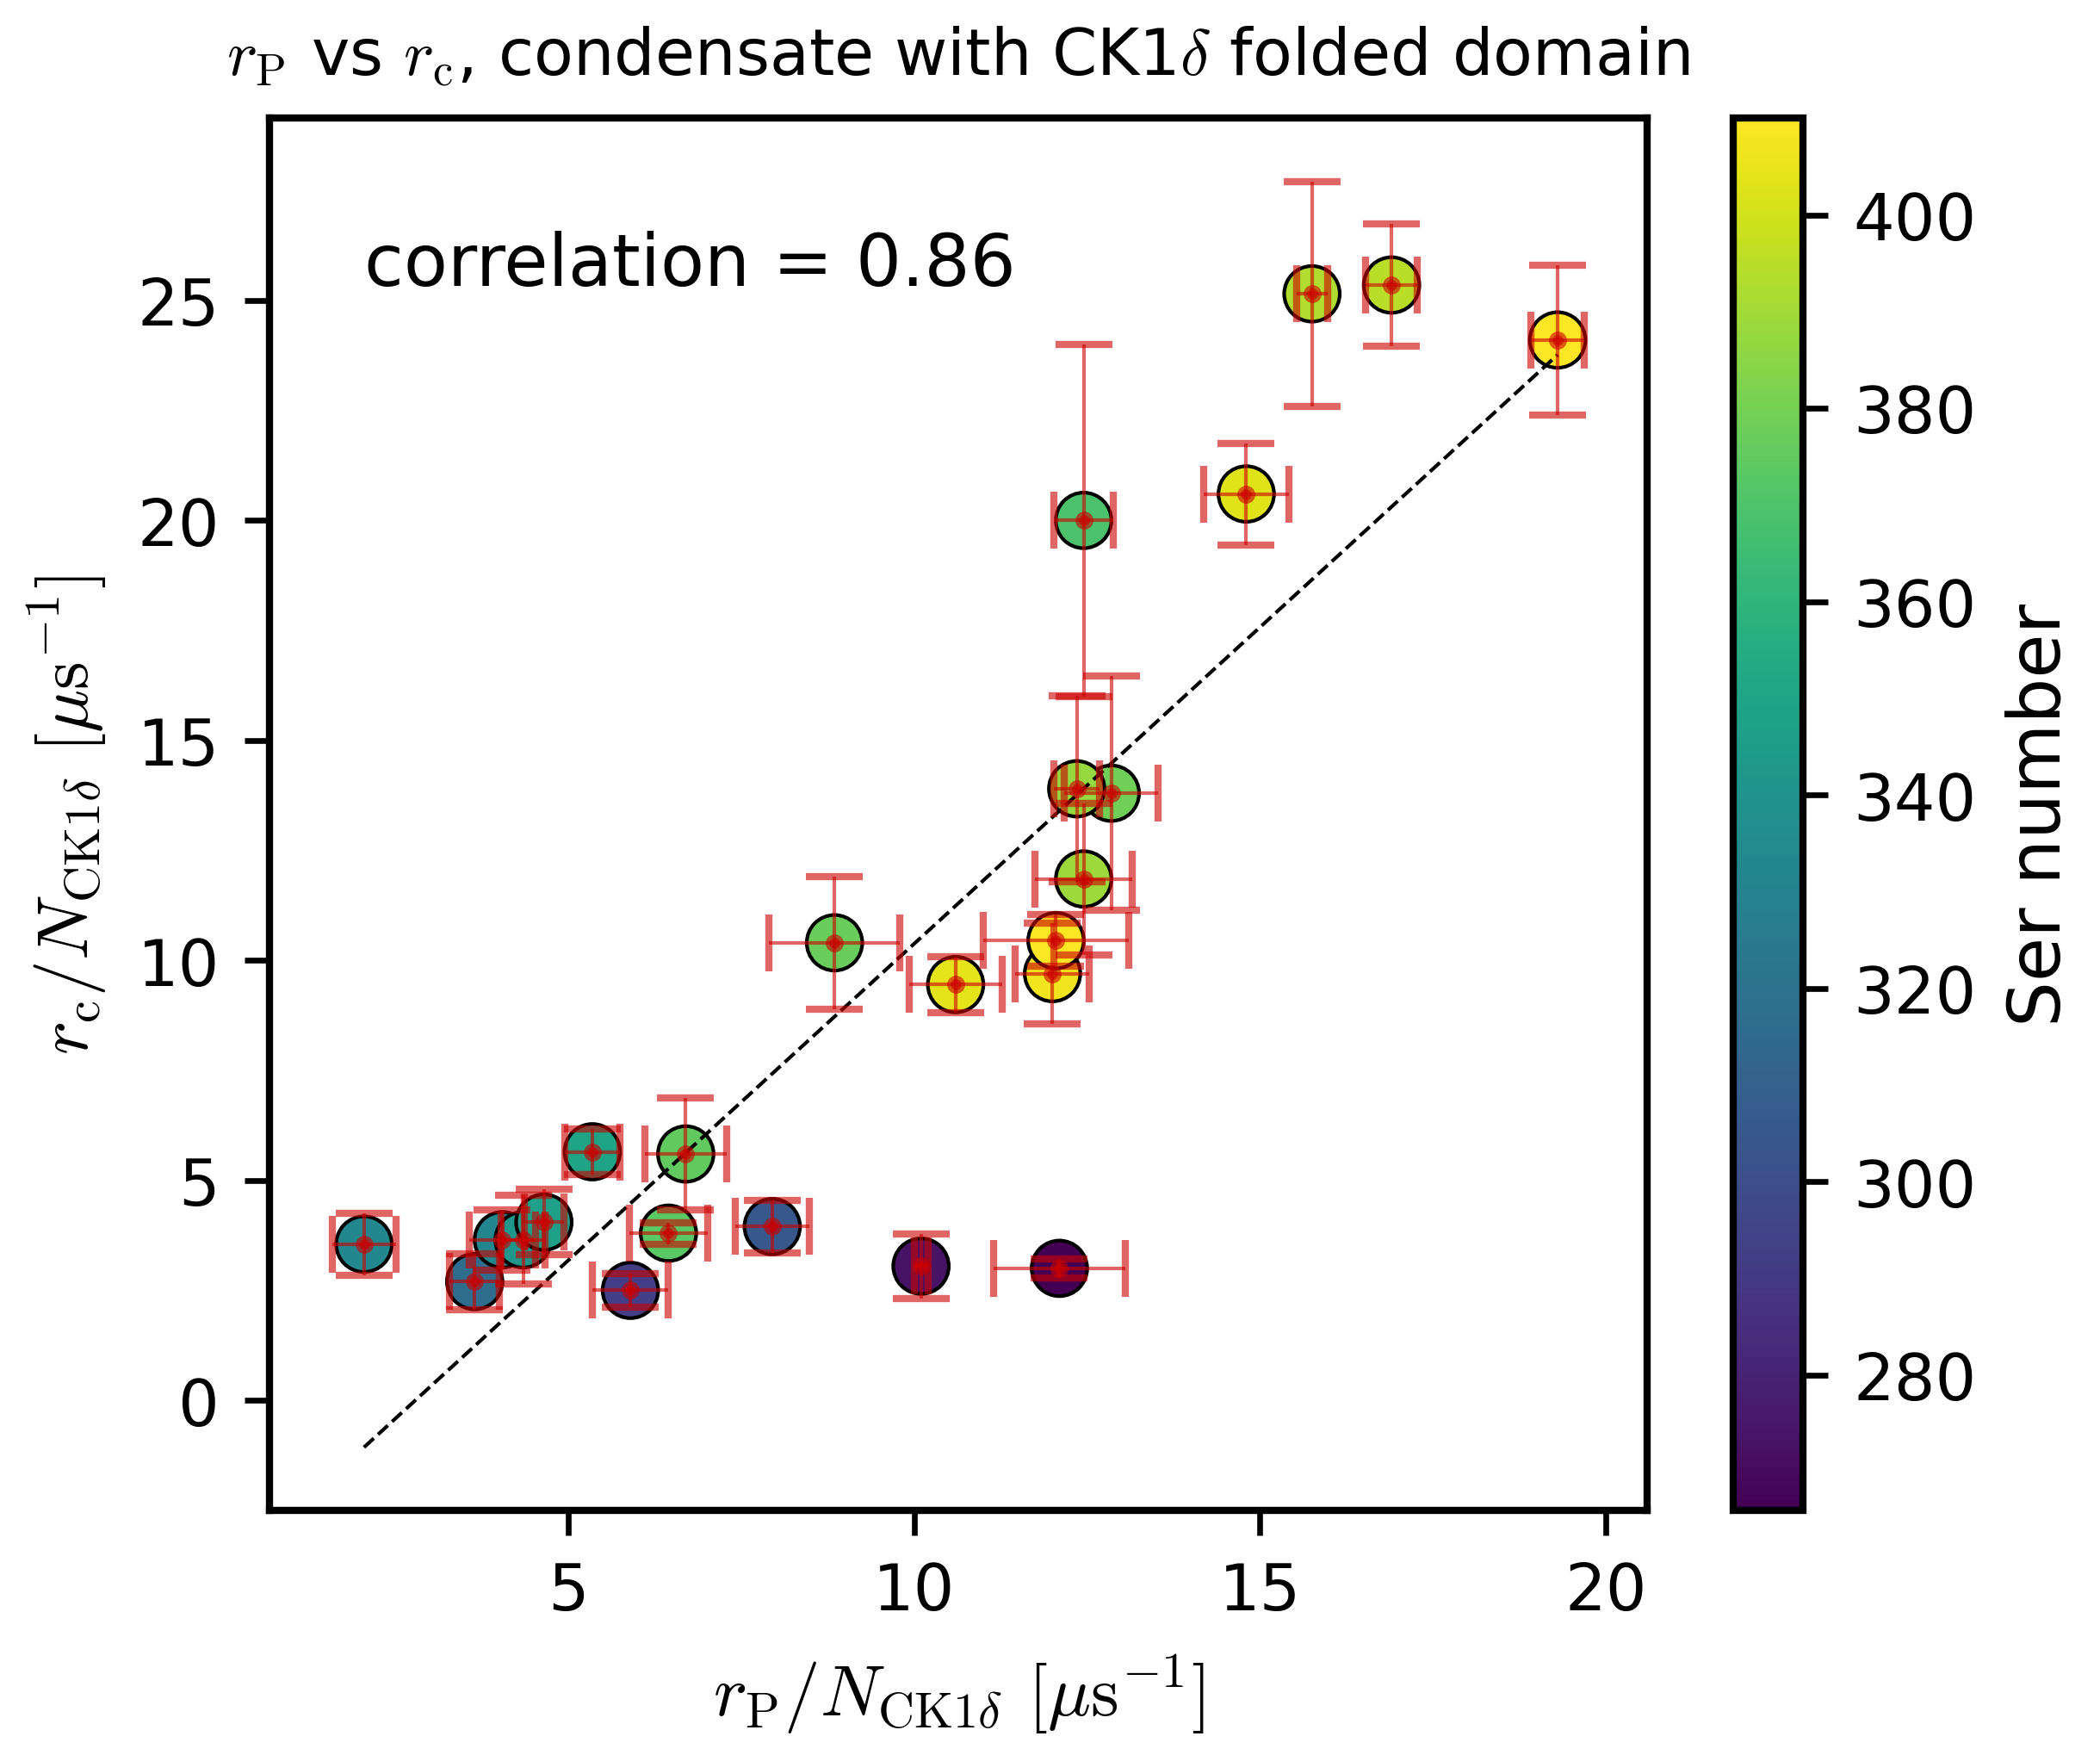

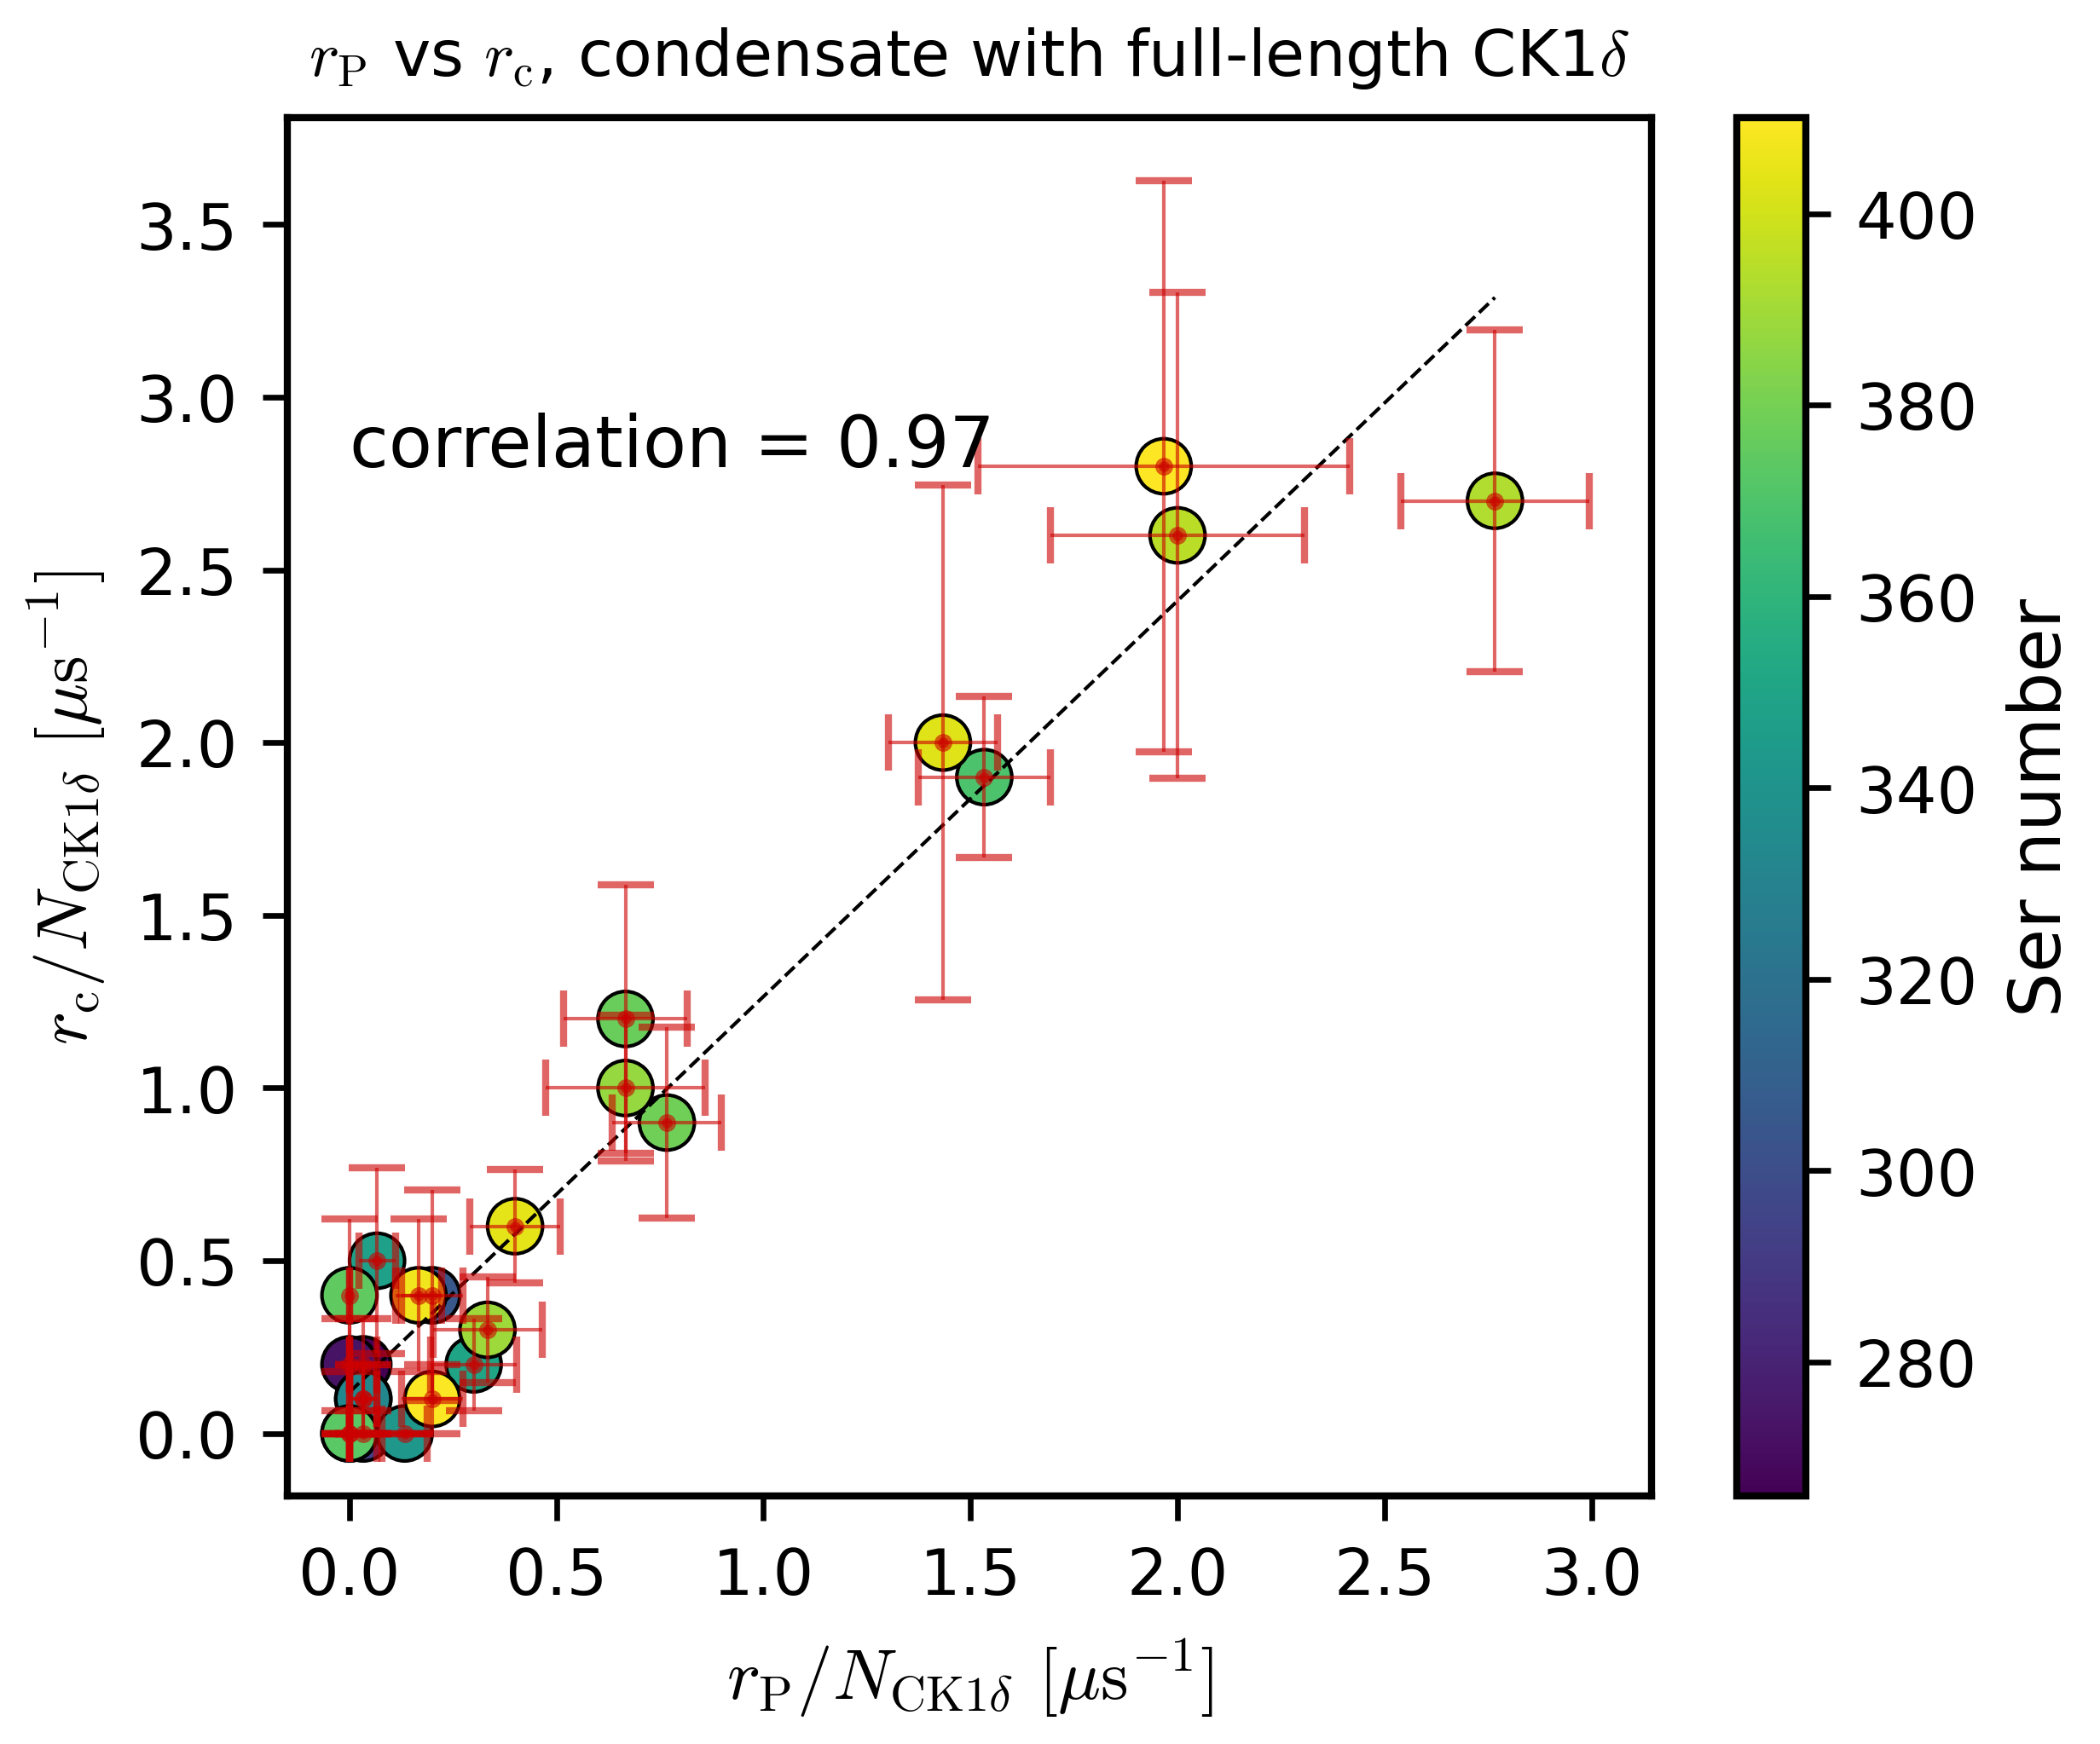

In [276]:
plot_correlation(rates, rc, drates, drc, ser_i+260, sing_ser=[21,23], 
                 title=r'$r_\mathrm{P}$ vs $r_\mathrm{c}$, single TDP-43, single CK1$\delta$ folded domain',
                xlabel=r'$r_\mathrm{P}$ $\mathrm{[\mu s^{-1}]}$',
                ylabel=r'$r_\mathrm{c}$ $\mathrm{[\mu s^{-1}]}$')
plot_correlation(rates_f, rc_f, drates_f, drc_f, ser_i+260,
                 title=r'$r_\mathrm{P}$ vs $r_\mathrm{c}$, single TDP-43, single full-length CK1$\delta$',
                xlabel=r'$r_\mathrm{P}$ $\mathrm{[\mu s^{-1}]}$',
                ylabel=r'$r_\mathrm{c}$ $\mathrm{[\mu s^{-1}]}$')

plot_correlation(rp_1c_fold, rc_1c_fold, drp_1c_fold, drc_1c_fold, ser_i+260,
                 title=r'$r_\mathrm{P}$ vs $r_\mathrm{c}$, condensate with CK1$\delta$ folded domain',
                xlabel=r'$r_\mathrm{P}/N_{\mathrm{CK1\delta}}$ $\mathrm{[\mu s^{-1}]}$',
                ylabel=r'$r_\mathrm{c}/N_{\mathrm{CK1\delta}}$ $\mathrm{[\mu s^{-1}]}$')

plot_correlation(rp_1c_full, rc_1c_full, drp_1c_full, drc_1c_full, ser_i+260, 
                 title=r'$r_\mathrm{P}$ vs $r_\mathrm{c}$, condensate with full-length CK1$\delta$',
                xlabel=r'$r_\mathrm{P}/N_{\mathrm{CK1\delta}}$ $\mathrm{[\mu s^{-1}]}$',
                ylabel=r'$r_\mathrm{c}/N_{\mathrm{CK1\delta}}$ $\mathrm{[\mu s^{-1}]}$')


/tmp/ipykernel_2176651/3911592421.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  color_bar = plt.colorbar(cm.ScalarMappable(norm=norm))


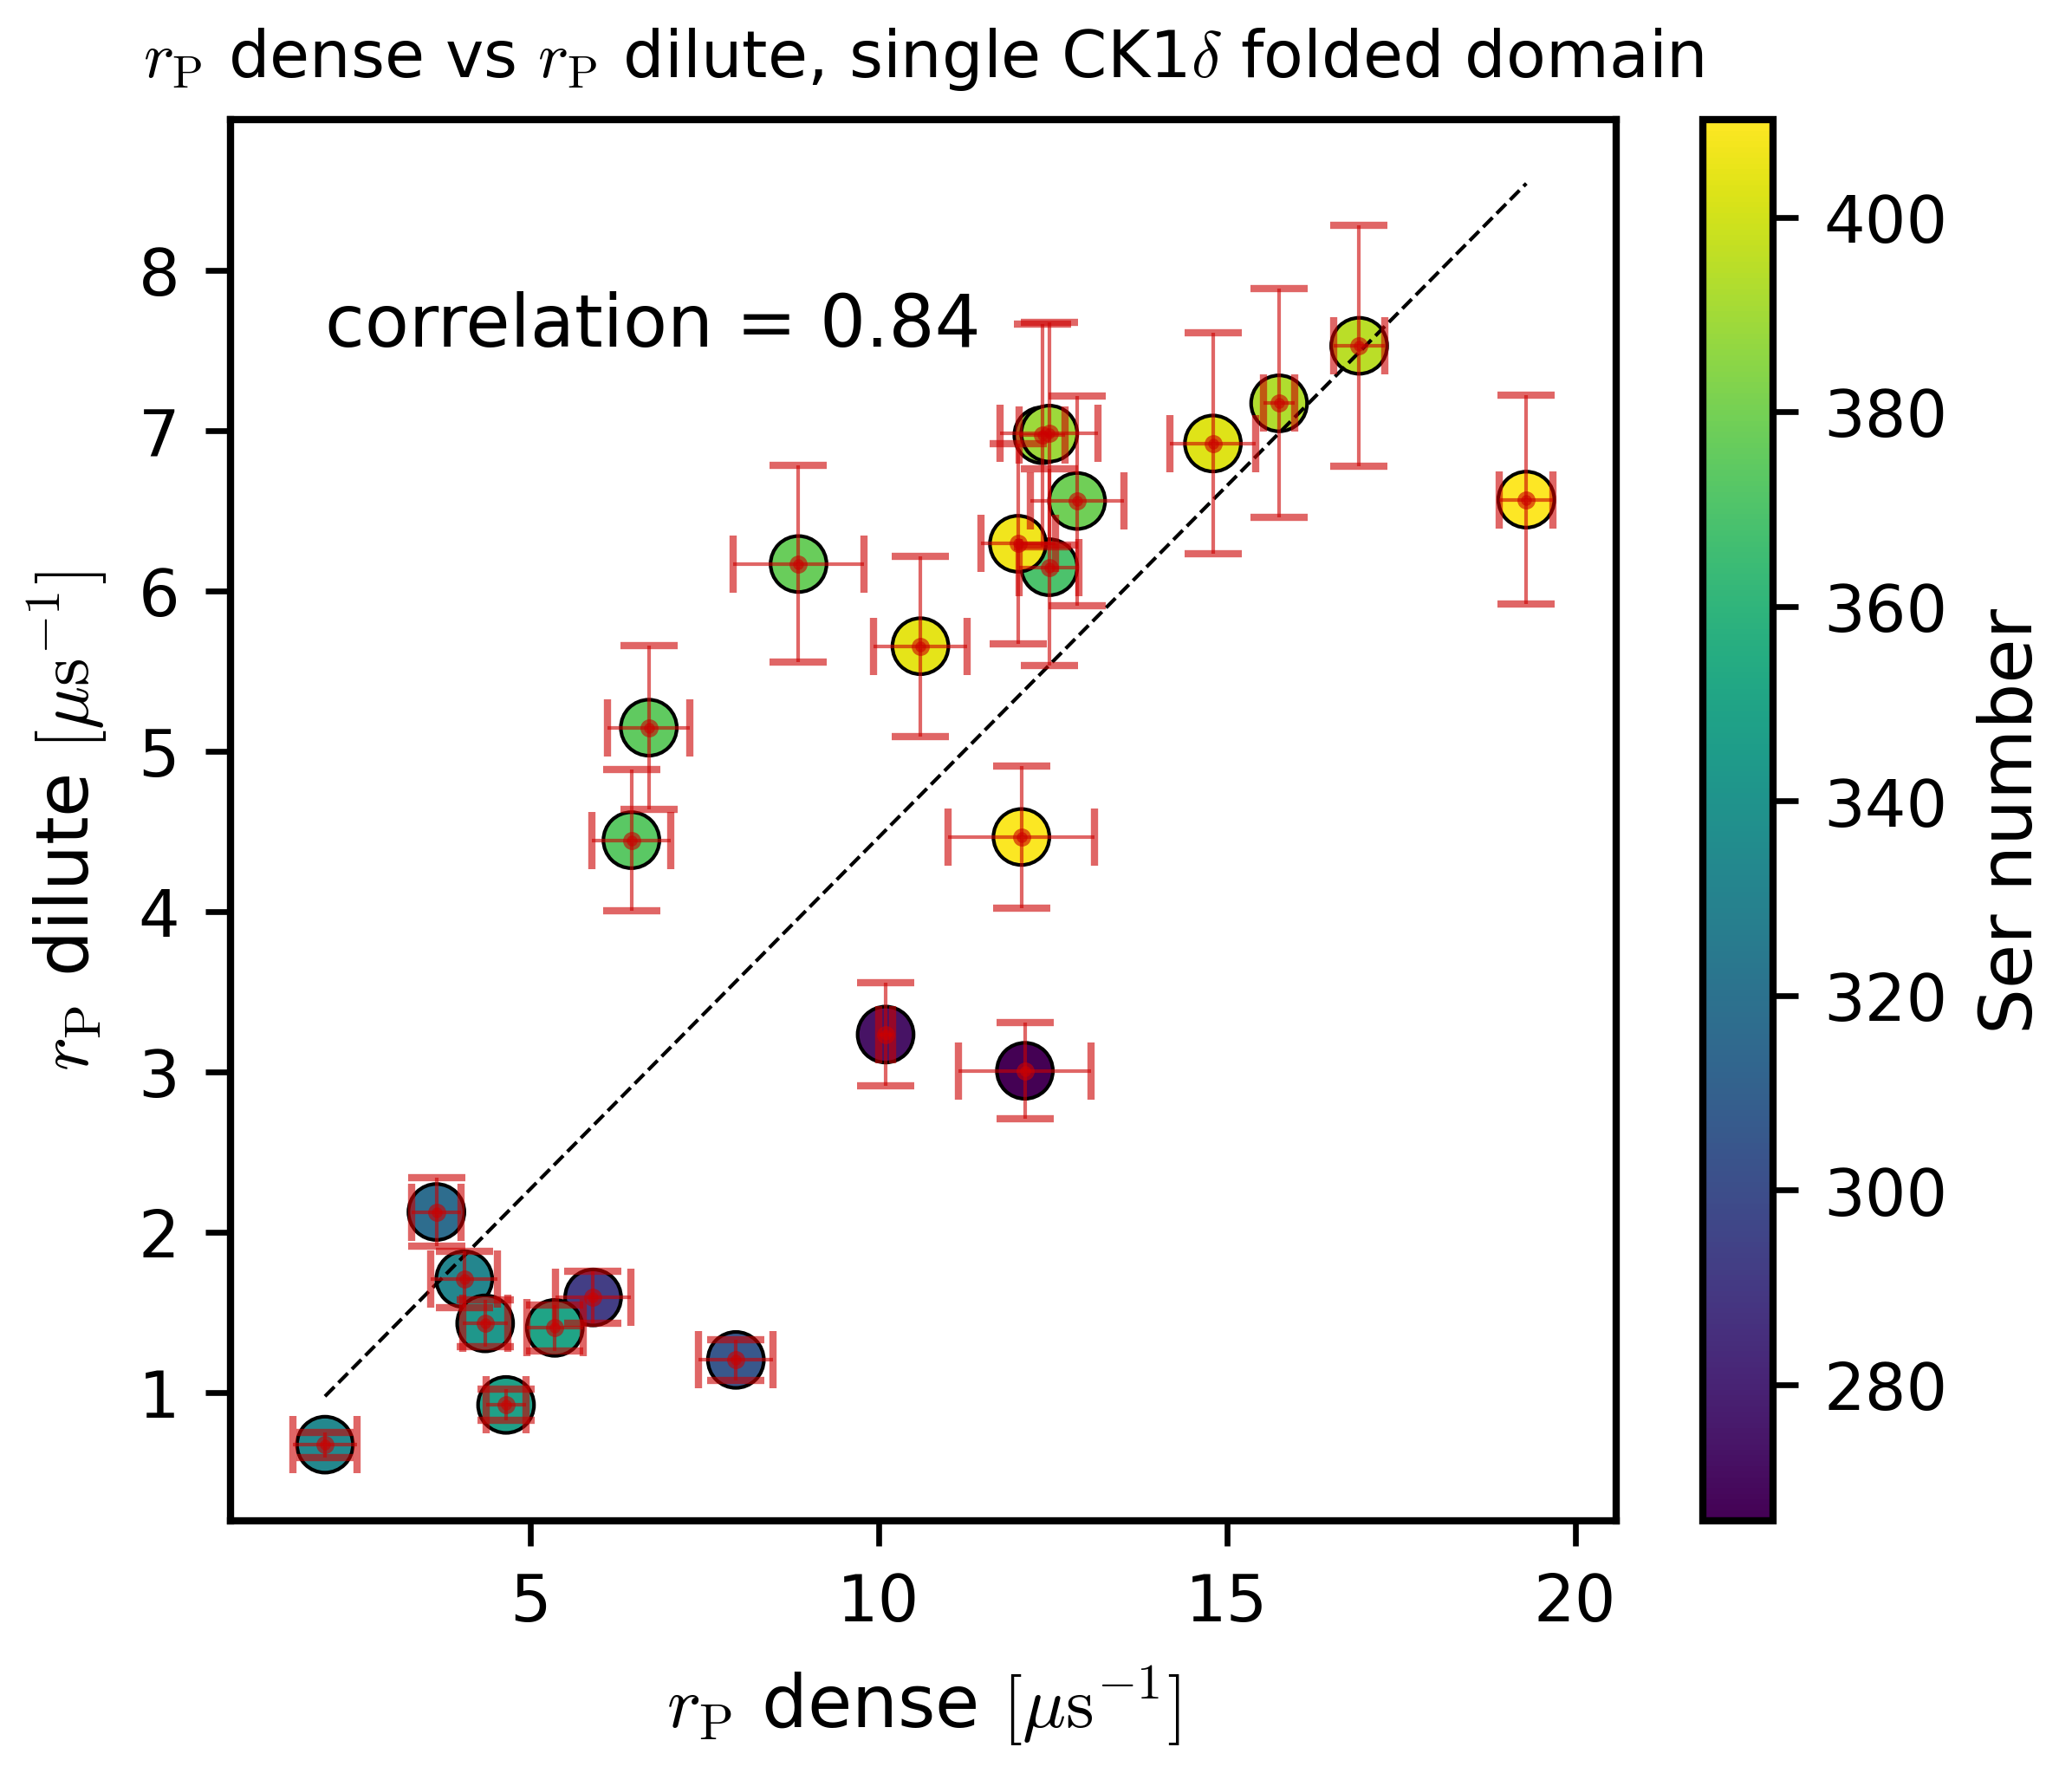

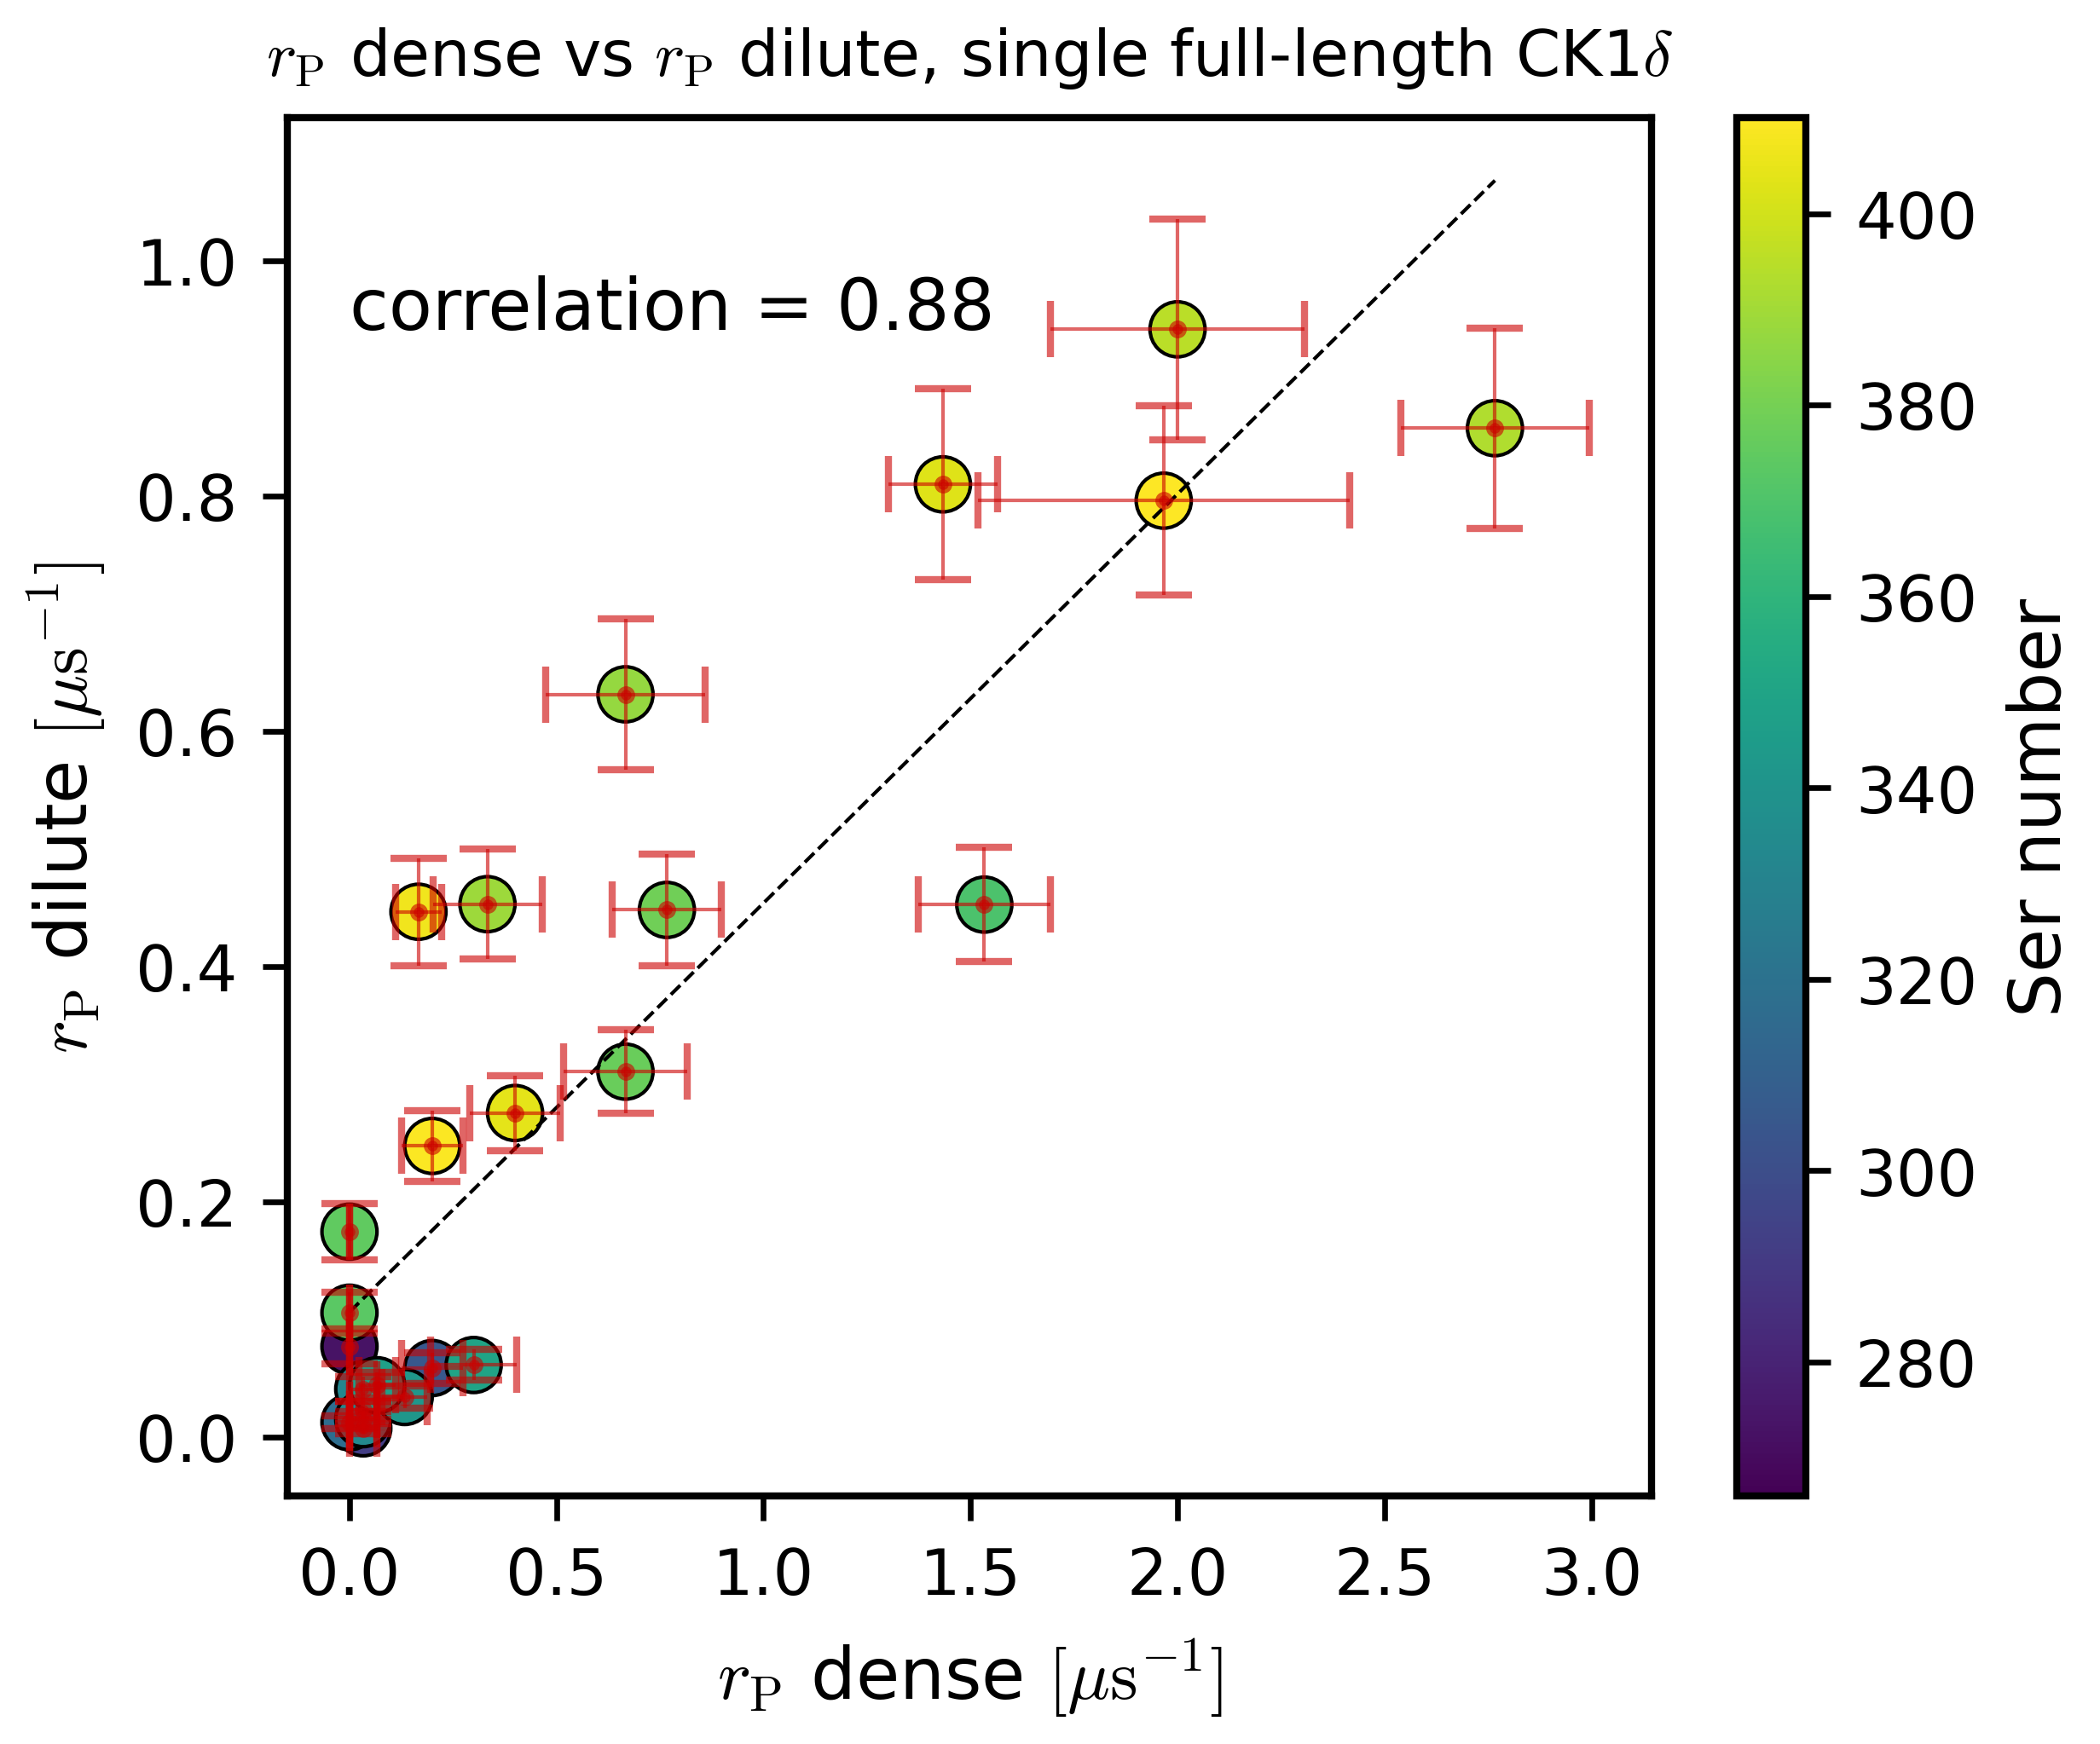

In [283]:
plot_correlation(rp_1c_fold, rates, drp_1c_fold, drates, ser_i+260,
                 title=r'$r_\mathrm{P}$ dense vs $r_\mathrm{P}$ dilute, single CK1$\delta$ folded domain',
                xlabel=r'$r_\mathrm{P}$ dense $\mathrm{[\mu s^{-1}]}$',
                ylabel=r'$r_\mathrm{P}$ dilute $\mathrm{[\mu s^{-1}]}$')

plot_correlation(rp_1c_full, rates_f, drp_1c_full, drates_f, ser_i+260, 
                 title=r'$r_\mathrm{P}$ dense vs $r_\mathrm{P}$ dilute, single full-length CK1$\delta$',
                xlabel=r'$r_\mathrm{P}$ dense $\mathrm{[\mu s^{-1}]}$',
                ylabel=r'$r_\mathrm{P}$ dilute $\mathrm{[\mu s^{-1}]}$',
                save='/localscratch/zippoema/md_plots/multi-tdp43/sim_full-ck1d/corr_rates_dense_vs_dilute_1-full.pdf')


## Exponential fits

In [354]:
ser_index = ser_i[23]

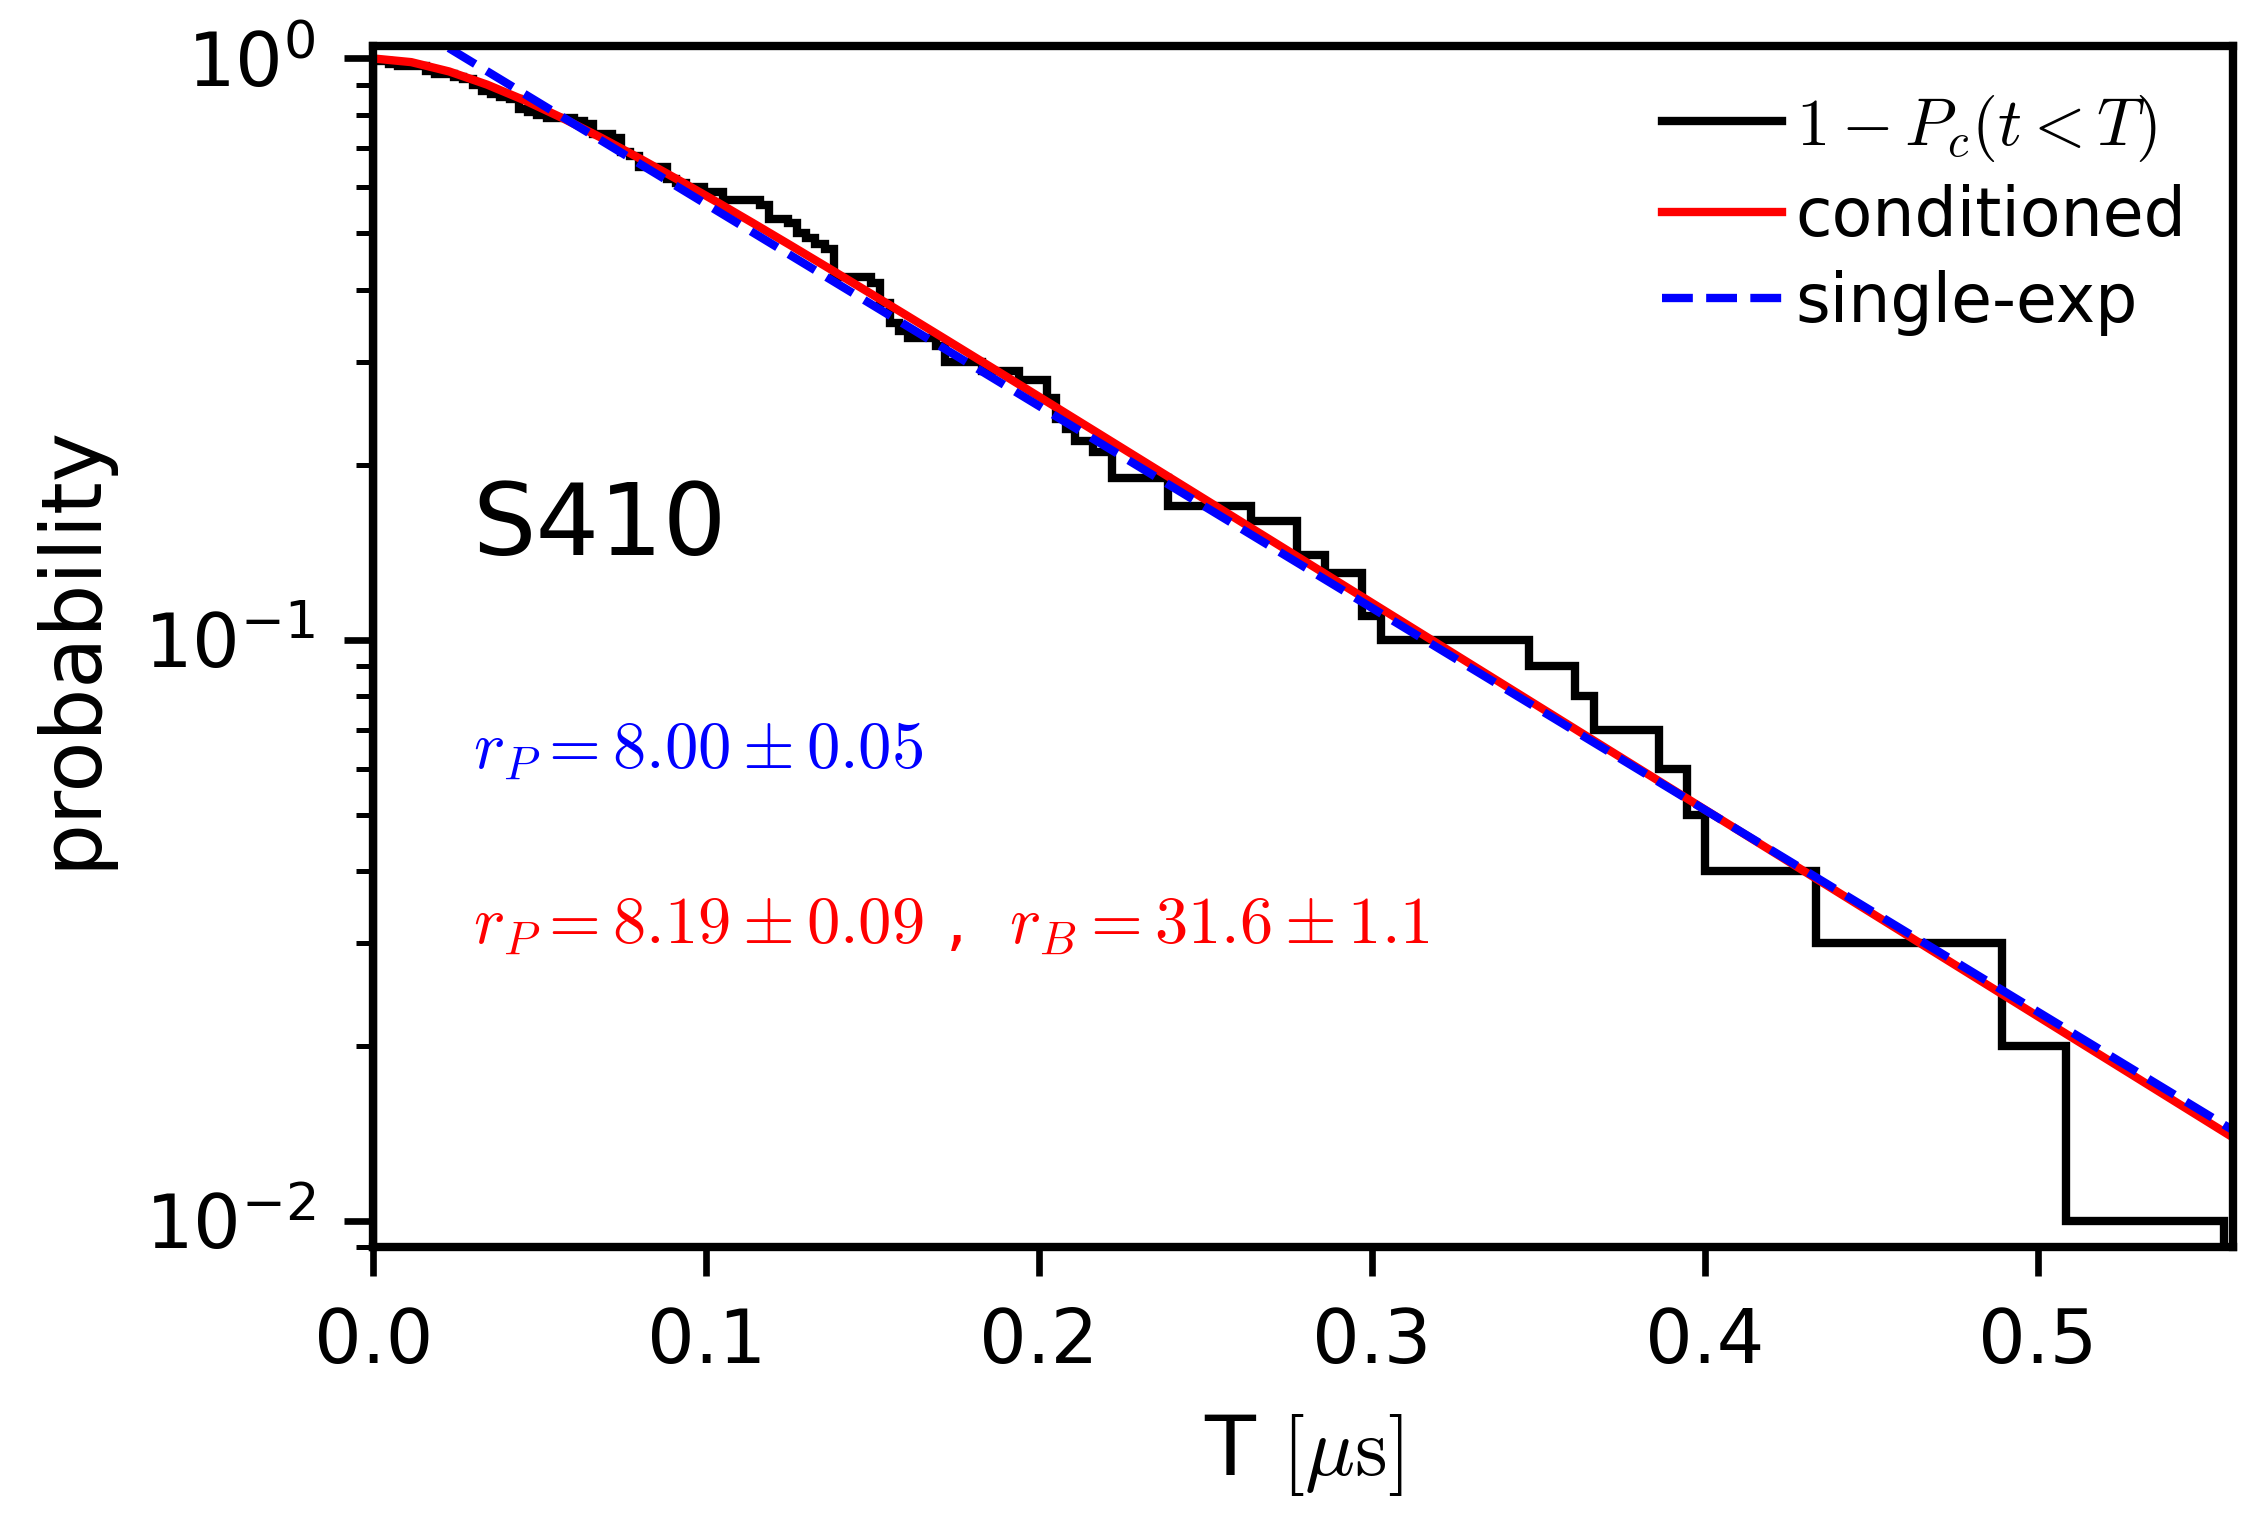

In [355]:
counts, bins = histogram_phosphorylation_times(dirpath='', file_suffix='short_ck1d-rigid-rescaled_tdp43_b30_32b_contacts.txt',
                                               ser_idx=ser_index, n_sims=100, max_time=2*10**8)
plot_exponential_fits(counts, bins, ser_idx=ser_index, same_rate=False, title=None, save=None)